# Table of Contents
* [LIGO summer 2016 workbook](#LIGO-summer-2016-workbook)
* [2016-05-25 20:19:35, New terms & toy problem](#2016-05-25-20:19:35,-New-terms-&-toy-problem)
* [2016-05-26 07:33:57, Skyped Craig](#2016-05-26-07:33:57,-Skyped-Craig)
* [2016-06-16 10:16:30, Starting Literature Review](#2016-06-16-10:16:30,-Starting-Literature-Review)
* [2016-06-16 14:03:31 Toy Problem take #2](#2016-06-16-14:03:31-Toy-Problem-take-#2)
* [2016-06-20 12:10:07 Lit and links](#2016-06-20-12:10:07-Lit-and-links)
* [2016-06-24 09:47:18 Playing with parameter modeling code](#2016-06-24-09:47:18-Playing-with-parameter-modeling-code)
* [2016-06-27 09:06:19  More papers](#2016-06-27-09:06:19--More-papers)
* [2016-07-05 11:31:21 Toy problem for stacking observations](#2016-07-05-11:31:21-Toy-problem-for-stacking-observations)
* [2016-07-06 10:24:36 Expanding the toy problem](#2016-07-06-10:24:36-Expanding-the-toy-problem)


# LIGO summer 2016 workbook

Missy McIntosh

# 2016-05-25 20:19:35, New terms & toy problem

___

New Terms: 

- **ringdown** : longish-duration, small bandwidth waveform

- **matched filter analysis**

- **chirp mass**

- **Kerr configuration**

- **wave deforms length slightly, returning light is out of phase**

- **resonant optical cavity**

- **signal recycling mirror**: ?

___
Toy Problem:

- make sine gauss
- add gauss white noise w/ rand
- run mcmc have it tell me freq of the sine wave within it, and amplitude, width, time of peak

minimal uncertainty wavelengths gabor uncertainty

duration is width of peak

width of peak in frequency space = 1/ delta time

generate templates by stepping through parameter space

data * template in time domain and freqency domain

* more noise at low and high frequencies, colored noise,

divide by noise spectrum , optimal match fitting

time off = destructive interference, small product
freq wrong, etc, small number

peaked is best, but noise will screw results up
___

- **Sine-Gaussian waves** : sine wave signals modulated by a Gaussian envelope. These are characterized by the signal's central frequency and the ratio of central frequency to bandwidth (quality factor).

Well, ok. Here's a sine wave: 

$$y(t) = A\sin(2 \pi f t + \varphi) = A\sin(\omega t + \varphi)$$
where:

$A$ = the amplitude, the peak deviation of the function from zero.
$f$ = the ordinary frequency, the number of oscillations (cycles) that occur each second of time.
$\omega$ = $2\pi f$, the angular frequency, the rate of change of the function argument in units of radians per second
$\varphi$ = the phase, specifies (in radians) where in its cycle the oscillation is at $t = 0$.
When $\varphi$ is non-zero, the entire waveform appears to be shifted in time by the amount $\varphi/\omega$ seconds. A negative value represents a delay, and a positive value represents an advance.


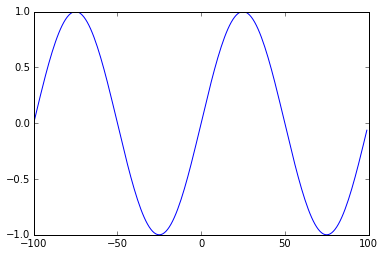

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_sine(amplitude,freq, sample_rate=100, phase=0):
    t = np.arange(-sample_rate,sample_rate)
    sinusoid = [amplitude*np.sin(2*np.pi*freq* (i/sample_rate)+ phase)  for i in t]
    return(t,sinusoid)

t,y = gen_sine(1,1)
plt.plot(t,y)
plt.show()

What's a sine-gaussian? Isn't that just like a wavepacket? 

Oh, look, Alan has a webpage on this stuff: https://labcit.ligo.caltech.edu/~ajw/bursts/burstsim.html

Which is conveniently depreciated. 

So it seems that Sine-Gaussian waves are of no astrophysical significance but can be used for "'swept-sine' calibration of our burst detection capability."

The waveforms that we are really interested in, those that might be from GW bursts are: 
- longish-duration, small bandwidth (ringdowns)
- longish-duration, large bandwidth (chirps)
- short duration, large bandwidth (merger)
- In-between (Zwerger-Muller or Dimmelmeier SN waveforms)

Anyway, the waveforms are:
- characterized by their frequency band, duration, and peak or root-sum-square amplitude
- in units of strain (that is, unitless)

And here's his Sine-Gaussian:
- h(t) = h0*exp(-(t-0.5).^2/tau^2).*sin(2*pi*f0*t); 
- My apologies for the historical use of tau instead of sigma_t = tau/sqrt(2).
- Peak amplitude h0 = 1.
- f0 = [100, 153, 235, 361, 554, 850, 1304, 2000]
- tau = 2/f0 (Q = sqrt(2)*pi*f0*tau = 8.88) or 
- tau = 2/3/f0 (Q = sqrt(2)*pi*f0*tau = 2.96)
- So, 8 central frequencies and 2 Q values = 16 waveforms

Okay, so it looks like: 

$$ h(t) = h_0 e^{-\frac{(t-0.5)^2}{\tau^2}} \sin(2\pi f_0 t) $$

or
$$ h(t) = h_0 e^{-\frac{(t-0.5)^2}{(2\sigma_t^2 )}} \sin(2\pi f_0 t) $$

but I think using $\sigma_t$ is preferred because it makes the Q-value, $Q=\sqrt{2}\pi f_0 \tau$, into $Q=2\pi f_0 \sigma_t$.

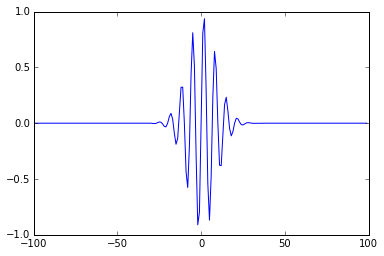

In [2]:
def gen_gaussian(t, sigma_t):
    gauss = [np.exp(-(i-0.5)**2/(2*sigma_t**2)) for i in t]
    return(t,gauss)
    
def gen_sinegauss(amplitude,freq, sigma_t, sample_rate=100, phase=0):
    t, sine = gen_sine(amplitude,freq,sample_rate, phase)
    t, gauss = gen_gaussian(t, sigma_t)
    sinegauss = [s*g for s,g in zip(sine, gauss)]
    return(t,sinegauss)

freq = 15
q = 800
sigma_t = q/(2*np.pi*freq)


t, sinegauss = gen_sinegauss(1,freq,sigma_t)
plt.plot(t,sinegauss)
plt.show()

Now for the white noise. 
- **white noise** : a random signal with a constant power spectral density;  a sequence of serially uncorrelated random variables with zero mean and finite variance; must be i.i.d.

Is drawing from random uniform ok? 

In [3]:
white_noise = np.random.uniform(-10,10,len(t))
np.var(white_noise)

31.973664809158105

Well. That isn't infinite. 

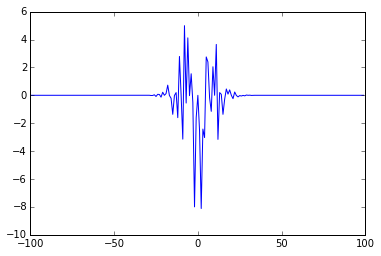

In [4]:
noisy_sinegauss = [s*n for s,n in zip(sinegauss, white_noise)]
plt.plot(t,noisy_sinegauss)
plt.show()

# 2016-05-26 07:33:57, Skyped Craig 

We went over control loop algebra and calibration and he gave me an ipython notebook for a toy problem he worked out.

This is the DARM (digital arm) spectrum: 

<img src="./figures/noise.png" style="width:700px;height:500px;">

and the quantum fluctuation/shot noise dominates at high frequencies, the seismic vibration (things like cars driving by) at low

<img src="./figures/block_diagram.png" style="width:700px;height:500px;"> 
Figure from \cite{abbott2016b}. 

We call the incoming signal $h(f) - a(f)$. 

\begin{align}
e(f) = & (h(f)-a(f))C(f)\\ 
-a(f) = & e(f)D(f)A(f)
\end{align}

combinded, we find:
    
\begin{align}
e(f) = & (h(f) - e(f)D(f)A(f))C(f) \\
e(f) = & h(f)C(f) - e(f)D(f)A(f)C(f) \\
e(f)(1+D(f)A(f)C(f)) = & h(f)C(f) \\
h(f) = & \frac{1+A(f)C(f)D(f)}{C(f)} e(f) \\
h(f) = & \frac{1 + G(f)}{C(f)} e(f)
\end{align}

where $G(f)$ is the open loop transfer function


here's his toy problem: 

https://gist.github.com/ccahilla/9b9738deb0bcf55155d2aba0058492c5
    
and he also said he would send me a code written by a grad student named Hill that has to do tracing errors in parameters that make up the $h(f) - a(f)$ signal

# 2016-06-16 10:16:30, Starting Literature Review

I'm reading \cite{abbott2016b} and \cite{Feedback2005}:

https://dcc.ligo.org/public/0122/P1500248/010/P1500248_EarlyaLIGOCalUncertainty.pdf
 
    
http://fraden.brandeis.edu/courses/phys39/Thermal%20Control/PID/Bechhoefer%20Feedback%20for%20physicists%20Rev%20Mod%20Phys%202005.pdf
    

# 2016-06-16 14:03:31 Toy Problem take #2

In [5]:
#Based off of Craig's code: https://gist.github.com/ccahilla/9b9738deb0bcf55155d2aba0058492c5
np.random.seed(123456789)   # repeatable results

def complex_sine_gaussian(central_time, central_freq, amplitude, phase, decay, time):
    return amplitude * np.exp(- decay * np.square(time - central_time)) * np.exp(1j*(2*np.pi*central_freq*(time - central_time) + phase))


So it looks like the equation for a complex sine Gaussian is: 

$$
Ae^{-d(t-t_c)^2}e^{2\pi f_c (t-t_c) + \phi}
$$

So maybe he used Euler's formula and rearranged?


\begin{aligned}e^{ix}&=\cos x+i\sin x\;\\e^{-ix}&=\cos(-x)+i\sin(-x)=\cos x-i\sin x\;\end{aligned}


$$ h(t) = h_0 e^{-\frac{(t-0.5)^2}{(2\sigma_t^2 )}} \sin(2\pi f_0 t) $$

Actually, I'm not sure. I will ask about that. 

The other change is to generate the white noise from a normal instead of uniform and to add instead of multiply it

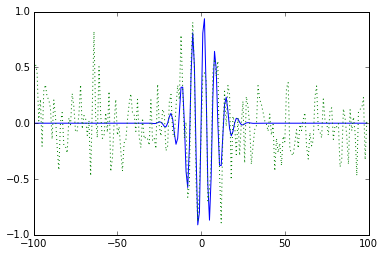

In [6]:
def gen_gaussian(t, sigma_t):
    gauss = [np.exp(-(i-0.5)**2/(2*sigma_t**2)) for i in t]
    return(t,gauss)
    
def gen_sinegauss(amplitude,freq, sigma_t, sample_rate=100, phase=0):
    t, sine = gen_sine(amplitude,freq,sample_rate, phase)
    t, gauss = gen_gaussian(t, sigma_t)
    sinegauss = [s*g for s,g in zip(sine, gauss)]
    return(t,sinegauss)

freq = 15
q = 800
sigma_t = q/(2*np.pi*freq)


t, sinegauss = gen_sinegauss(1,freq,sigma_t)
plt.plot(t,sinegauss)


white_noise = np.random.normal(0,0.25,len(t))
np.var(white_noise)

noisy_sinegauss = sinegauss+white_noise
plt.plot(t,noisy_sinegauss, ':')
plt.show()

In [7]:
# Slightly modified Craig's code:
Amp_signal = np.sqrt(np.mean(np.square(noisy_sinegauss)));
Amp_noise  = np.sqrt(np.mean(np.square(white_noise)));
SNR = np.square(Amp_signal/Amp_noise)
print('RMS Amplitude of the signal = ', Amp_signal)
print( 'RMS Amplitude of the noise = ', Amp_noise)
print( 'SNR = ', SNR)

RMS Amplitude of the signal =  0.286445655586
RMS Amplitude of the noise =  0.229769980285
SNR =  1.55416779626


Okay. Now time for the MCMC part. 

MCMCs are a way to generate statistical samples from probability distributions when integrating the probability distribution is too hard. They are a class of algorithms of which Metropolis-Hastings is the most popular (I think) but I use Goodman & Weare's algorithm in the emcee python package. 

burn in info:
http://users.stat.umn.edu/~geyer/mcmc/burn.html


In [8]:
# Craig's code again:
# Define Log Likelihood

uncs = noise_std * np.ones(len(t))  # Uniform uncertainty in each point
def lnprob(theta, t, signal, uncs) :
    tc = theta[0]
    fc = theta[1]
    amplitude = theta[2]
    phase = theta[3]
    a = theta[4]
    
#     a = b * fc**2
    if (tc < t[0] or t[-1] < tc or fc <= 0 or fc >= 0.5/(t[1]-t[0]) or 
        amplitude <= 0 or amplitude > 5.0 or phase < -np.pi or phase >= np.pi or a <= 0 or a > 150.0):
        return -np.inf
    else :
        new_signal = np.real(complex_sine_gaussian(tc, fc, amplitude, phase, a, t));
        return -np.sum(np.abs(signal - new_signal)**2/(2*np.square(uncs)))

NameError: name 'noise_std' is not defined

# 2016-06-20 12:10:07 Lit and links



This paragraph from \cite{abbott2016b} seems to have information pertinent to my project purpose: 

"Though not yet the dominant source of error, based on the
expected sensitivity improvement of Advanced LIGO [32], calibration
uncertainties may limit astrophysical measurements
in future observing runs. In the coming era of numerous detections
of gravitational waves from diverse sources, accurate
estimation of source populations and properties will depend
critically on the accuracy of the calibrated detector outputs of
the advanced detector network. In the future, the calibration
physical model and its uncertainty will be directly employed
in the astrophysical parameter estimation procedure, which
will reduce the impact of this uncertainty on the estimation
of source parameters. We will continue to improve on the
calibration accuracy and precision reported here, with the goal
of ensuring that future astrophysical results are not limited by
calibration uncertainties as the detector sensitivity improves
and new sources are observed."

I was looking through http://www.ligo.org/ and I found these cool things: 

https://www.youtube.com/watch?v=KwbXxzgAObU

https://www.youtube.com/watch?v=3pK5oenm5gw

http://www.ligo.org/multimedia/gallery/opt.php

https://www.ligo.caltech.edu/gallery

http://www.gwoptics.org/

http://epo.sonoma.edu/EposChronicles/?p=3623&lang=en

https://www.youtube.com/channel/UCMATJmzibndbcdY8s9Prhjg

less interesting

http://www.amnh.org/sciencebulletins/content/a.f.gravity.20041101/assets/115/

http://www.amnh.org/sciencebulletins/content/a.f.gravity.20041101/assets/114/

http://spaceplace.nasa.gov/ligo-g-waves/en/

Videos:
"LIGO: A passion for understanding"
"LIGO Generations"

I also found some digital signal processing stuff and looked up info on Binder

# 2016-06-24 09:47:18 Playing with parameter modeling code

In [ ]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
%matplotlib inline
#notebook
plt.rc('text', usetex=False)
plt.rcParams['mathtext.default']='regular'
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["font.size"] = 14.0

infiles = glob.glob('../data/*')
print(infiles)

Parameter list from /home/kent/lsc/master/bin/cbcBayesPostProc.py
massParams=['mtotal','m1','m2','mc']
    distParams=['distance','distMPC','dist']
    incParams=['iota','inclination','theta_jn']
    polParams=['psi','polarisation','polarization']
    skyParams=['ra','rightascension','declination','dec']
    timeParams=['time']
    spinParams=['spin1','spin2','a1','a2','a1z','a2z','phi1','theta1','phi2','theta2',
    'chi','effectivespin','chi_eff','chi_tot','chi_p','beta','tilt1','tilt2','phi_jl','theta_jn','phi12']
    sourceParams=['m1_source','m2_source','mtotal_source','mc_source','redshift']
intrinsicParams=massParams+spinParams
    extrinsicParams=incParams+distParams+polParams+skyParams
    sourceFrameParams=sourceParams+distParams

In [ ]:

df = pd.read_csv(infiles[0], sep='\t')
df.columns = df.columns.str.replace('Unnamed: 0','name')
print(df.name.values)
parameters = ['redshift','distance', 'mtotal', 'mc','matched_filter_snr', 'ra', 'dec', 'q', 'eta','psi','cosiota']
statistics = df.columns.values[1:-3]
statistics = [s for s in statistics if s != 'KL']

In [ ]:

def plotparams(parameter, statistic, ax, log=False):
    
    neffs = []
    values = []
    people = []
    for file in infiles: 
        neff = file.split('neff')[1].split(".dat")[0]
        
        try:
            neff = float(neff)
            person = 'm'
        except:
            try:
                person = neff[-1]
                neff = float(neff[:-1])
            except:
                person = neff[-2]
                neff = float(neff[:-2])
            
        df = pd.read_csv(file, sep='\t')
        value = df.loc[df['Unnamed: 0'] == (parameter)][statistic].values[0]
        neffs.append(neff)
        values.append(value)
        people.append(person)
    try:
        #fig = plt.figure(figsize=(10,5))
        #ax = fig.add_subplot(111)
        colordict = {'m':'r', 'k':'b'}
        plt.title('{0}'.format(statistic, parameter))
        if log:
            for i in np.arange(len(values)):
                plt.scatter(np.log10(values[i]), np.log10(neffs[i]), color=colordict[people[i]], label=people[i])
            plt.xlabel(r'$log_{10}$'+'{0}'.format(parameter))
            plt.ylabel(r'$log_{10}n_{eff}$')
        else:
            for i in np.arange(len(values)):
                plt.scatter(values[i], neffs[i], color=colordict[people[i]], label=people[i])
            plt.xlabel('{0}'.format(parameter))
            plt.ylabel(r'$n_{eff}$')
            
        handles, labels = ax.get_legend_handles_labels()
        display = (0,1)
        
        #ax.legend([handle for i,handle in enumerate(handles) if i in display],
        #      ['kent', 'missy'])
        #plt.show()
              
    except:
        print('issue with {0}, {1}'.format(parameter, statistic))

In [ ]:
for parameter in parameters:
        fig = plt.figure()
        fig.suptitle(' '*50+'{0}'.format(parameter), size=20, y=1.08)
        gs = gridspec.GridSpec(1, len(statistics))
        gs.update(wspace=0.001)
        for i,statistic in enumerate(statistics): 
            if i == 0: 
                ax = plt.subplot(gs[0, i])
            else:
                ax = plt.subplot(gs[0, i], sharey=ax)
                plt.setp(ax.get_yticklabels(), visible=False)
                plt.setp(ax.yaxis.get_label(), visible=False)
            plotparams(parameter, statistic, ax)
            plt.setp(ax.get_xticklabels(), rotation=45)

        gs.tight_layout(fig, rect=[0, 0, 2, 1])
        plt.show()


In [ ]:
matplotlib.pyplot.close("all")

# 2016-06-27 09:06:19  More papers

Here's some reference having to do with the actual LIGO instrument

http://adsabs.harvard.edu/abs/1995OptL...20.1507R
http://www.sciencedirect.com/science/article/pii/037596019390620F
http://www.sciencedirect.com/science/article/pii/037596019390620F

And then Allen gave me a few on testing GR:
https://dcc.ligo.org/public/0122/P1500213/031/paper.pdf
https://dcc.ligo.org/public/0122/P1500218/014/PhysRevLett.116.241102.pdf
https://dcc.ligo.org/public/0124/P1600088/016/bbh-o1.pdf

and TIGER:
http://arxiv.org/pdf/1311.0420v2.pdf

Alan said he would rather me not go into depth about the code/how mcmc works but just say what they do

# 2016-07-05 11:31:21 Toy problem for stacking observations

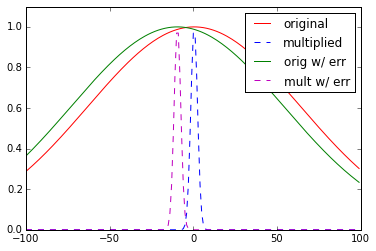

In [87]:
# generate gaussian with some width, multiply a few of them to see if the peak narrows 

freq = 0.1
q = 10*4
sigma_t = q/(2*np.pi*freq)
sample_rate = 100
t = np.arange(-sample_rate,sample_rate)


t, gauss = gen_gaussian(t,sigma_t)
n = 10**3
multgauss = [g**n for g in gauss]
plt.plot(t,gauss, 'r', label="original")
plt.plot(t,multgauss, 'b', linestyle = "--",label="multiplied")

# add a deliberate systematic error, multiply a few to see if the peak will not narrow
err = -10
_, err_gauss = gen_gaussian([i-err for i in t],sigma_t)
err_multgauss = [g**n for g in err_gauss]
plt.plot(t, err_gauss, 'g', label="orig w/ err")
plt.plot(t, err_multgauss, 'm', linestyle = "--",label="mult w/ err")
plt.ylim(0,1.1)

plt.legend()
plt.show()

# yep

# 2016-07-06 10:24:36 Expanding the toy problem

Here we want to use a template of the boxing day GW signal and generate a family of templates which are slightly modified in amplitude and phase during ringdown. Then we will add white (and eventually colored) noise to a copy one of these templates to create some faux data. We will feed this faux data and all our templates through a matched filtering function, which will return the template with the highest SNR. We will look at the amplitude and phase perturbations of the returned templates as a function of the match filter's SNR. We will also compare the returned amplitudes and phase perturbations to the true amplitude and phase perturbation of the template we used to make the faux data. 

- need to whiten the data
- need to use colored noise
- also alter fmin
- will rescale template in time and amplitude, interpolating to get back original time axis to generate 10-50 solar mass signals
- will use these, recovered with very low SNR, then multiply their posteriors

In [1]:
import os 
import sys
path = '/Users/mmcintosh/GoogleDrive/LIGO/tutorials/GW150914_tutorial'
sys.path.insert(0, path)
os.chdir(path)


# Get the boxing day template and matched filter engine from losc event tutorial, 
# https://losc.ligo.org/s/events/GW151226/LOSC_Event_tutorial_GW151226.html
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
# I used python-modernize on this so it works with 3.4
import readligo

eventname = 'GW151226' 


In [2]:
## getting the template– this is all from https://losc.ligo.org/s/events/GW151226/LOSC_Event_tutorial_GW151226.html
# Read the event properties from a local json file
fnjson = "O1_events.json"
events = json.load(open(fnjson,"r"))

# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)


# get the template
f_template = h5py.File(fn_template, "r")
# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

time = np.linspace(0,16, len(template_p))
ttime = time-time[0]-template_offset
dt = time[1] - time[0]
GRtemplate = (template_p + template_c*1.j) 

Reading in parameters for event GW151226
{'utcevent': '2015-12-26T03:38:53.65', 'f_min': 10.0, 'a2': -0.0396, 'approx': 'lalsim.SEOBNRv2', 'm1': 19.6427, 'fn_H1': 'H-H1_LOSC_4_V1-1135136334-32.hdf5', 'tevent': 1135136350.65, 'URL': 'https://losc.ligo.org/s/events/GW151226/', 'm2': 6.7054, 'fn_template': 'GW151226_4_template.hdf5', 'fn_L1': 'L-L1_LOSC_4_V1-1135136334-32.hdf5', 'name': 'GW151226', 'fs': 4096, 'a1': 0.3998, 'fband': [43.0, 800.0]}


In [280]:
print(dt)


0.00012207124383


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in sqrt
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


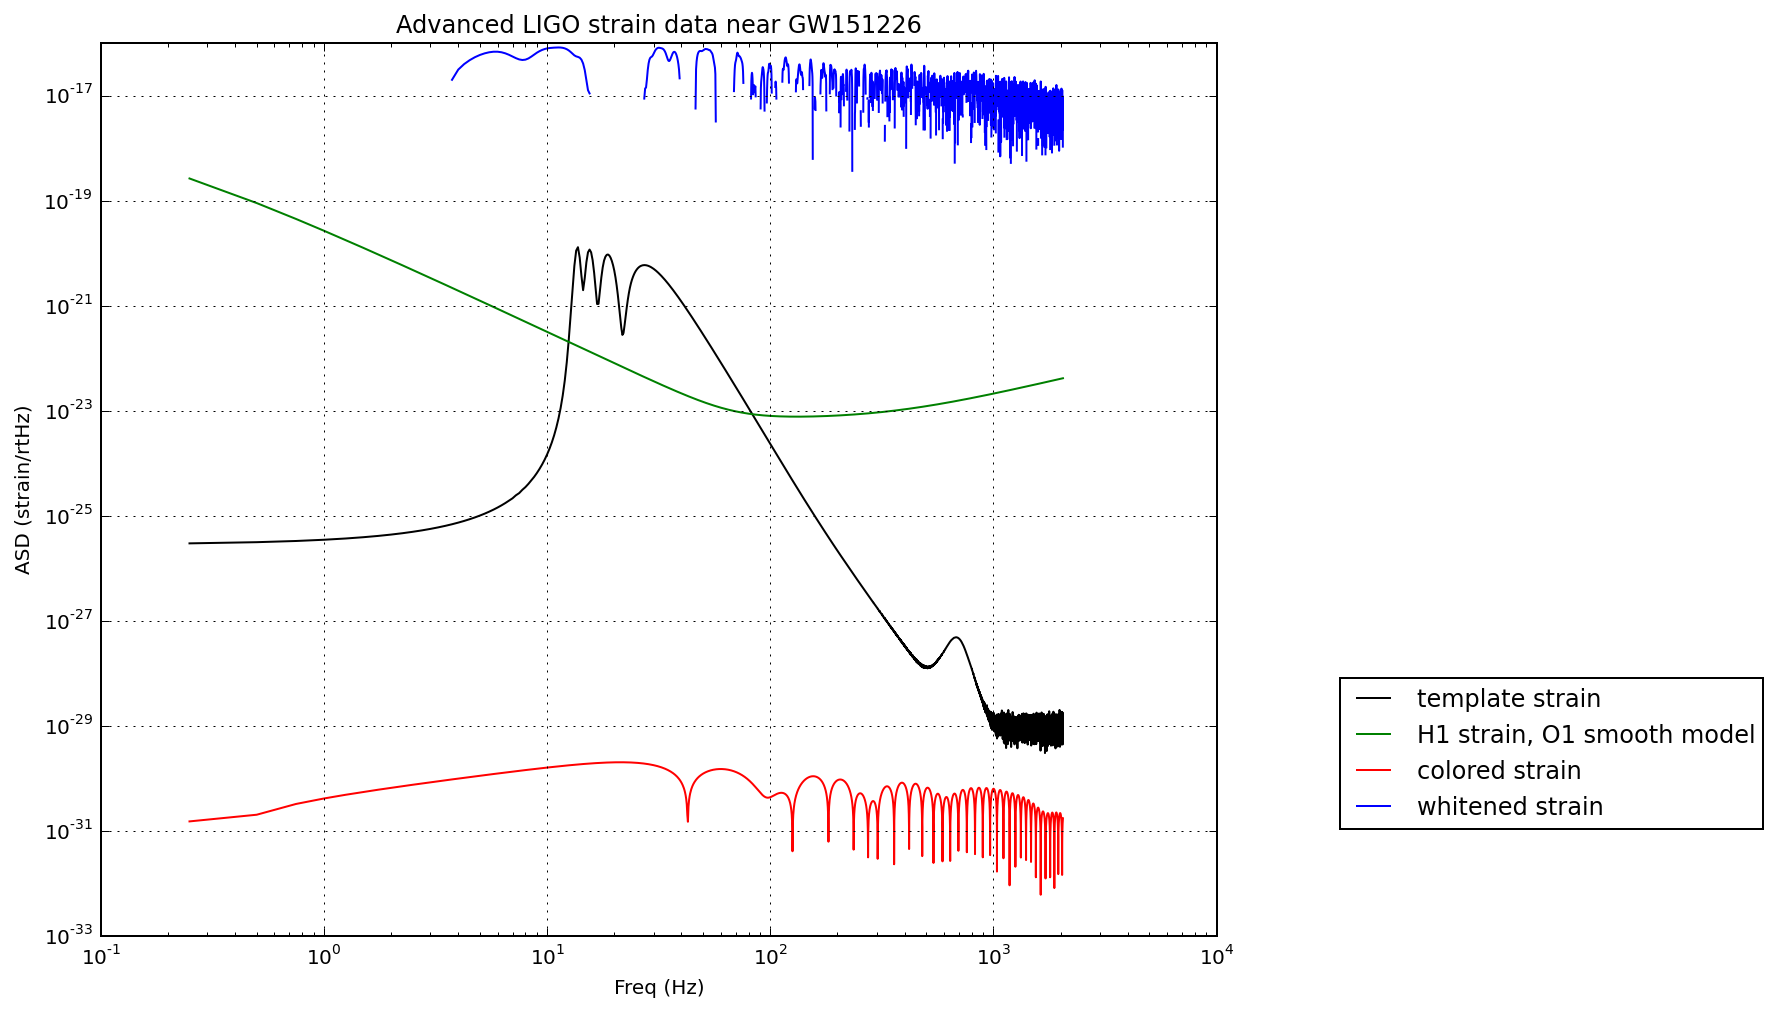

In [32]:
# plot ASD/strain equivalent noise vs frequency; mostly from 
# https://losc.ligo.org/s/events/GW151226/LOSC_Event_tutorial_GW151226.html

# plot the ASDs, with the template overlaid:
f_min = 20.
f_max = 2000. 
plt.figure(figsize=(10,8))
NFFT = 4*fs

strain, freqs = mlab.psd(GRtemplate, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd = interp1d(freqs, strain, fill_value='extrapolate')
plt.loglog(freqs, np.sqrt(strain),'k',label='template strain')

# Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
psd_smooth = interp1d(freqs, Pxx)
plt.loglog(freqs, np.sqrt(Pxx),'g',label='H1 strain, O1 smooth model')
#plt.axis([f_min, f_max, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.title('Advanced LIGO strain data near '+eventname)


# whiten and bandpass the data, mostly from 
# https://losc.ligo.org/s/events/GW151226/LOSC_Event_tutorial_GW151226.html


# "color" the data (multiply it by the noise amplitude spectrum, in the fourier domain)
def colorit(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    colored_hf = hf * (np.sqrt(interp_psd(freqs) /dt/2.))
    colored_ht = np.fft.irfft(colored_hf, n=Nt)
    return np.abs(colored_ht)



# "whiten" the data (divide it by the noise amplitude spectrum, in the fourier domain)
# no longer in units of strain; now in units of "sigmas" away from the mean
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return np.abs(white_ht)


colored_strain = colorit(strain,psd,dt)
plt.loglog(freqs, np.sqrt(colored_strain),'r', label='colored strain')


psd = interp1d(freqs, colored_strain, fill_value='extrapolate')
whitened_strain = whiten(colored_strain,psd,dt)

# We need to suppress the high frequency noise (no signal!) with some bandpassing:
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
whitened_bp_strain = filtfilt(bb, ab, whitened_strain)

plt.loglog(freqs, np.sqrt(whitened_bp_strain),'b',label='whitened strain')
plt.legend(bbox_to_anchor=(0., 0.2, 1.5, .102))
plt.show()


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in sqrt
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


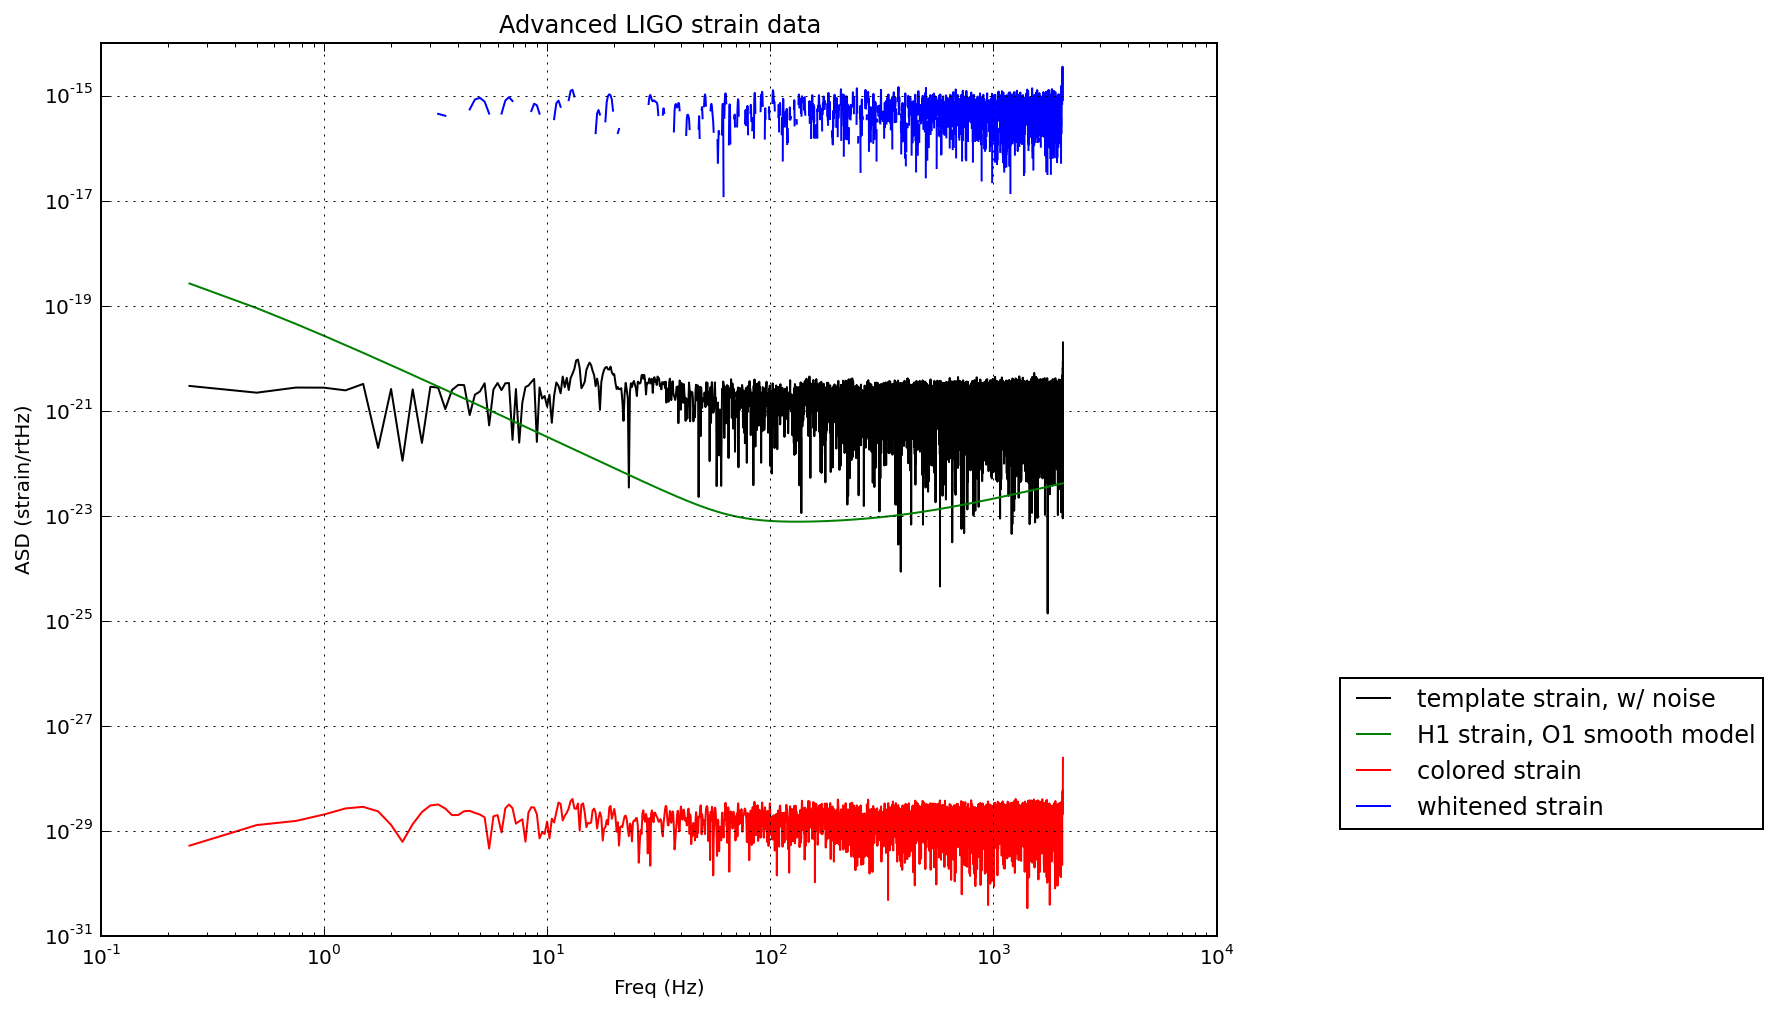

In [35]:
# now let's add some white noise
def whitenoise(template, noise_level):
    if noise_level==0:
        return(template)
    else:
        scale = 10**-40
        # transform to freq domain
        Nt = len(template)
        freqs = np.fft.rfftfreq(Nt, dt)
        hf = np.fft.rfft(template)
        white_noise = np.random.uniform(0,noise_level,len(hf))*scale
        noisy_data = hf+white_noise
        data = np.fft.ifft(noisy_data, n=len(template))
    return(data)

strain, freqs = mlab.psd(GRtemplate, Fs = fs, NFFT = NFFT)

noise_level = 50
noisy_strain = whitenoise(strain, noise_level)


# We will use interpolations of the ASDs computed above for whitening:
psd = interp1d(freqs, noisy_strain, fill_value='extrapolate')
plt.figure(figsize=(10,8))
plt.loglog(freqs, np.sqrt(noisy_strain),'k',label='template strain, w/ noise')

# Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
psd_smooth = interp1d(freqs, Pxx)
plt.loglog(freqs, np.sqrt(Pxx),'g',label='H1 strain, O1 smooth model')
#plt.ylim(1e-24, 1e-5)
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.title('Advanced LIGO strain data')



colored_strain = colorit(noisy_strain,psd,dt)
plt.loglog(freqs, np.sqrt(colored_strain),'r', label='colored strain')


psd = interp1d(freqs, colored_strain, fill_value='extrapolate')

whitened_strain = whiten(colored_strain,psd,dt)

whitened_bp_strain = filtfilt(bb, ab, whitened_strain)


plt.loglog(freqs, np.sqrt(whitened_bp_strain),'b',label='whitened strain')
plt.legend(bbox_to_anchor=(0., 0.2, 1.5, .102))

plt.show()


In [282]:
# this whole function is from 
# https://losc.ligo.org/s/events/GW151226/LOSC_Event_tutorial_GW151226.html

def matchfiltering(template, data):
    
     # -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
    #   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
    NFFT = 4*fs
    psd_window = np.blackman(NFFT)
    # and a 50% overlap:
    NOVL = NFFT/2

    # define the complex template, common to both detectors:
    #template = (template_p + template_c*1.j) 

    # We will record the time where the data match the END of the template.
    etime = time+template_offset
    # the length and sampling rate of the template MUST match that of the data.
    datafreq = np.fft.fftfreq(template.size)*fs
    df = np.abs(datafreq[1] - datafreq[0])

    # to remove effects at the beginning and end of the data stretch, window the data
    # https://en.wikipedia.org/wiki/Window_function#Tukey_window
    try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
    except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

    # prepare the template fft.
    template_fft = np.fft.fft(template*dwindow) / fs

    


    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]


            
    return(SNRmax)


Error compiling Cython file:
------------------------------------------------------------
...

def matchfiltering(template, data):
    
     # -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
    #   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
    NFFT = 4*fs
              ^
------------------------------------------------------------

/Users/mmcintosh/.ipython/cython/_cython_magic_aa58830a534ca296cbe56cfa154dbc9e.pyx:8:15: undeclared name not builtin: fs

Error compiling Cython file:
------------------------------------------------------------
...
def matchfiltering(template, data):
    
     # -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
    #   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
    NFFT = 4*fs
    psd_window = np.blackman(NFFT)
                  ^
------------------------------------------------------------

Here I am modifying the template by a constant-frequency amplitude scale and phase shift. I transform from complex rectangular coordinates to complex polar coordinates to do this. I transform back at the end. 

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


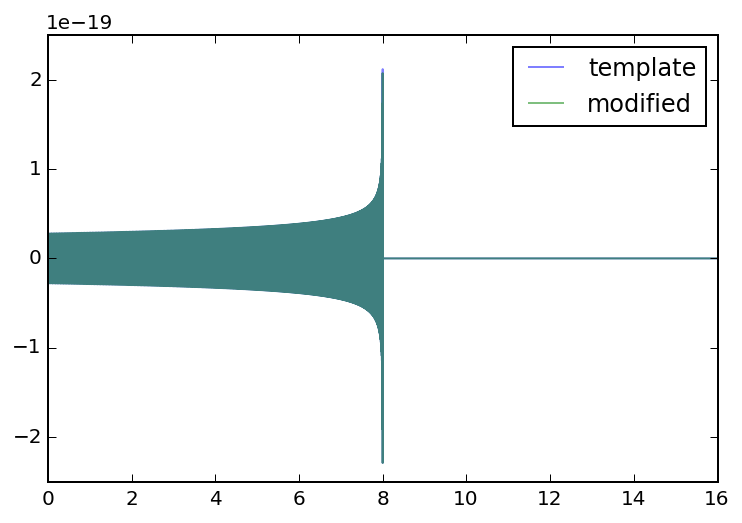

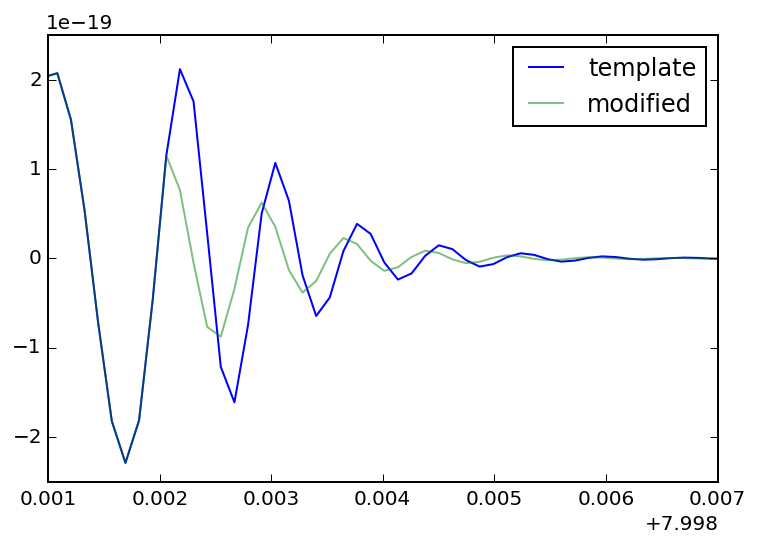

In [38]:
# modify the amplitude and phase of the template
# this is my code now

import cmath as c
def shiftphase(rectangular_coords, phase_shift):
    r, phi = c.polar(rectangular_coords)
    shifted_phi = phi + phase_shift
    shifted_rectangular = c.rect(r,shifted_phi)
    return(shifted_rectangular)
def modifyringdown(template,amplitude,phase):
    max_index = np.argmax(template)
    mod_ringdown = [shiftphase(x,phase)*amp for x in GRtemplate[max_index:]]
    mod_template = np.concatenate([template[:max_index],mod_ringdown])
    return(mod_template)

amp = 0.5
phase = np.pi/3
mod_template = modifyringdown(GRtemplate,amp,phase)



scale = 10**-19
plt.plot(time, GRtemplate, alpha = 0.5, label="template")
plt.plot(time,mod_template, alpha=0.5,label="modified")
plt.ylim(-2.5*scale,2.5*scale)
plt.legend(loc=0)
plt.show()

plt.plot(time, GRtemplate, label="template")
plt.plot(time,mod_template, alpha=0.5,label="modified")
plt.ylim(-2.5*scale,2.5*scale)
plt.xlim(7.999,8.005)
plt.legend(loc=0)
plt.show()

Here I generate 100 templates with different constant-frequency amplitude scales and phase shifts

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


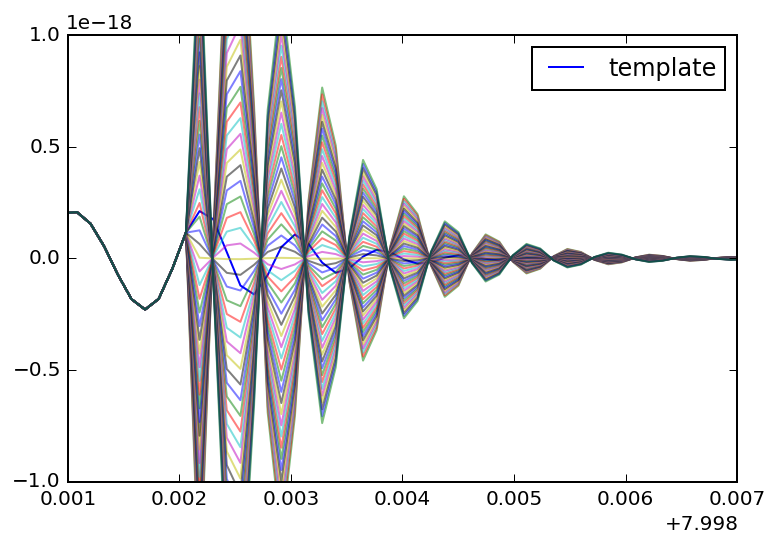

500


In [39]:
n = 500

# make a family of templates
class Template(object):
    number = 0
    timeseries = []
    amp = 0
    phase = 0

    def __init__(self, number, timeseries, amp, phase):
        self.number = number
        self.timeseries = timeseries
        self.amp = amp
        self.phase = phase

def make_template(number, timeseries, amp, phase):
    template = Template(number, timeseries, amp, phase)
    return(template)

amps = np.linspace(-10,10,n)
phases = np.zeros(n)#np.linspace(0,2*np.pi,n)

#amps = np.linspace(0.5,1.5,n)
#phases = np.pi/(np.linspace(0.1,2,n))

plt.plot(time, GRtemplate, label="template")
templates = []
i = 0
for amp in amps:
    #for phase in phases: 
    timeseries = modifyringdown(GRtemplate,amp,phase)
    template = make_template(i,timeseries,amp,phase)
    templates.append(template)
    if (i % 10) == 0:
        plt.plot(time,template.timeseries, alpha=0.5)
    i+=1
plt.ylim(-10*scale,10*scale)
plt.xlim(7.999,8.005)
plt.legend()
plt.show()
print(len(templates))

0.0200400801603 1.0471975511965976


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


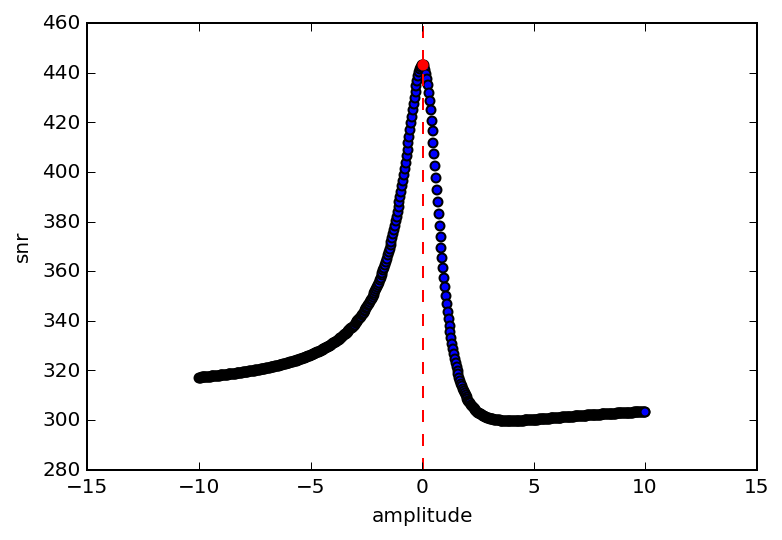

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)


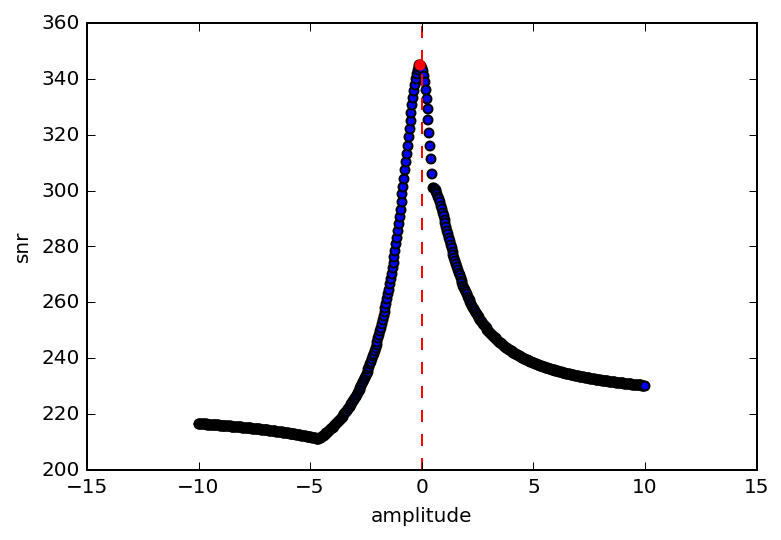

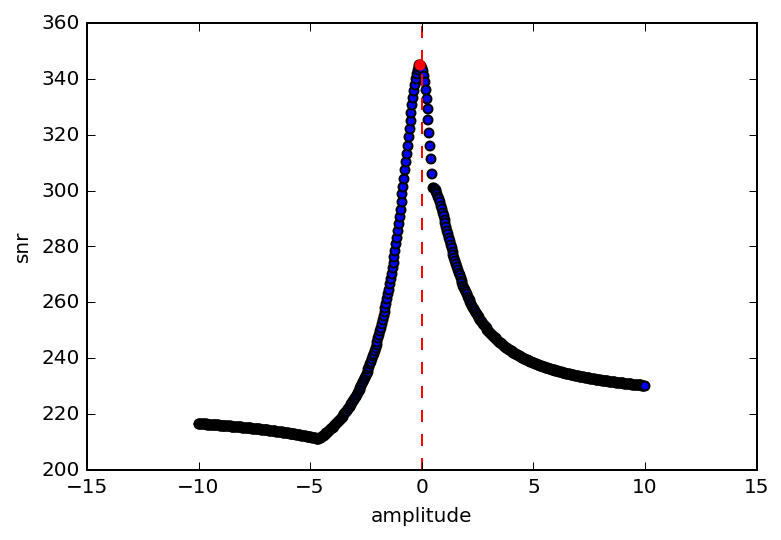

In [200]:
noise_levels = [0,10,1000]

number = int(len(templates)/2)
datatemplate = templates[number]
print(datatemplate.amp, datatemplate.phase)



for noise_level in noise_levels: 

    data = whitenoise(datatemplate.timeseries, noise_level)
    snr_arr = [matchfiltering(template.timeseries,data) for template in templates]

    amps = [template.amp for template in templates]
    phases = [template.phase for template in templates]

    plt.scatter(amps,snr_arr)
    plt.scatter(amps[np.argmax(snr_arr)],np.max(snr_arr),color='r', label='{0}:{1}'.format(templates[np.argmax(snr_arr)].number, number))
    plt.axvline(datatemplate.amp,ymin=0, ymax=450,linestyle='--',color='r', label="true amplitude, {0}".format(datatemplate.amp))
    plt.ylabel('snr')
    plt.xlabel('amplitude')
    plt.show()

    '''
    plt.scatter(phases,snr_arr)
    plt.scatter(phases[np.argmax(snr_arr)],np.max(snr_arr), color='r')
    plt.axvline(datatemplate.phase,ymin=0, ymax=450,linestyle='--',color='r', label="true")
    plt.ylabel('snr')
    plt.xlabel('phase')
    plt.show()
    '''

[ 0.42414747  5.63323032]
[  5.99006046  21.20902011]


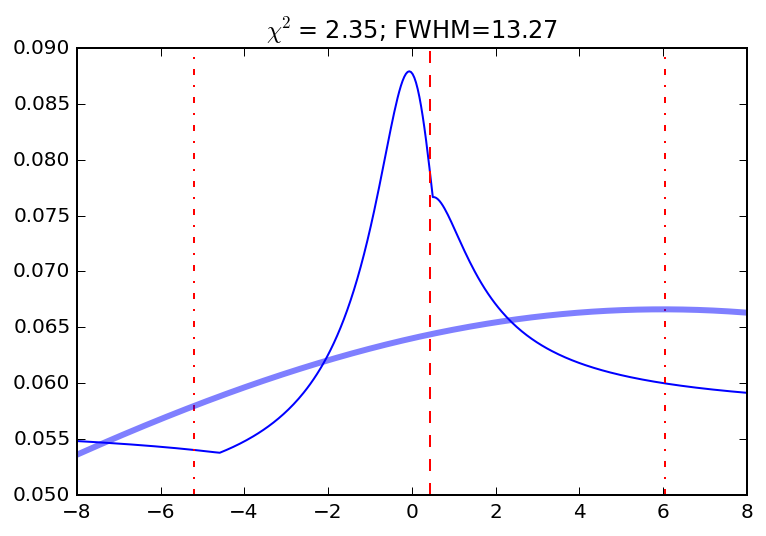

In [197]:
# from http://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak
import scipy.optimize as opt

def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))



X = np.asarray(amps)
Y = np.asarray(snr_arr)

# Renormalize to a proper PDF
xmin = np.min(X)
xmax = np.max(X)
N = len(X)
Y /= ((xmax-xmin)/N)*Y.sum()


# trim the data
n = 10
number = int(len(templates)/n)
X = X[number:-number]
Y = Y[number:-number]

# Renormalize to a proper PDF
xmin = np.min(X)
xmax = np.max(X)
N = len(X)
Y /= ((xmax-xmin)/N)*Y.sum()



# Fit a guassian
p0 = [0,100]#[amps[np.argmax(snr_arr)],100000] # Inital guess is a normal distribution
errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
print(p1)
#p1 = [p1[0],0.45]

fit_mu, fit_stdev = p1

FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev

plt.plot(X,Y)
#plt.plot(X, gauss(X,p1),lw=3,alpha=.5, color='r')

plt.axvline(fit_mu,ymin=0, ymax=450,linestyle='--',color='r')
plt.axvline(fit_mu+fit_stdev,ymin=0, ymax=450,linestyle='-.',color='r')
plt.axvline(fit_mu-fit_stdev,ymin=0, ymax=450,linestyle='-.',color='r')
#axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.5)


from scipy.stats import chisquare
 
observed_values=Y
expected_values=gauss(X,p1)
 
chi2, pvalue = chisquare(observed_values, f_exp=expected_values)
plt.title(r'$\chi^2$= {0:.2f}; FWHM={1:.2f}'.format(chi2, FWHM))



def gauss(x, mu, stdev): # p[0]==mean, p[1]==stdev
    return 1.0/(mu*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*stdev**2))

from scipy.optimize import curve_fit
popt, pcov = curve_fit(gauss, X, Y)#, bounds=([-8,0],[np.inf,8]))
print(popt)
stdev = np.sqrt(np.diag(pcov))
plt.plot(X, gauss(X,popt[0], popt[1]),lw=3,alpha=.5, color='b')
plt.show()

In [287]:
def stackpdfs(n_events, noise_level):
    indices = np.random.randint(0, len(templates)-1, n_events)
    product = 1 
    pdfs = []
    for i in indices: 
        datatemplate = templates[i]
        data = whitenoise(datatemplate.timeseries, noise_level)
        snr_arr = np.asarray([matchfiltering(template.timeseries,data) for template in templates])

        amps = np.asarray([template.amp for template in templates])
        #phases = np.asarray([template.phase for template in templates])

        # Renormalize to a proper PDF
        xmin = np.min(amps)
        xmax = np.max(amps)
        N = len(amps)
        snr_arr /= ((xmax-xmin)/N)*snr_arr.sum()

        popt, pcov = curve_fit(gauss, amps, snr_arr)

        pdf = gauss(amps,popt[0], popt[1])
        product *= pdf
        #stdev = np.sqrt(np.diag(pcov))
        #pdfs.append(pdf)
        #FWHM = 2*np.sqrt(2*np.log(2))*stdev
        return(product)
        


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)


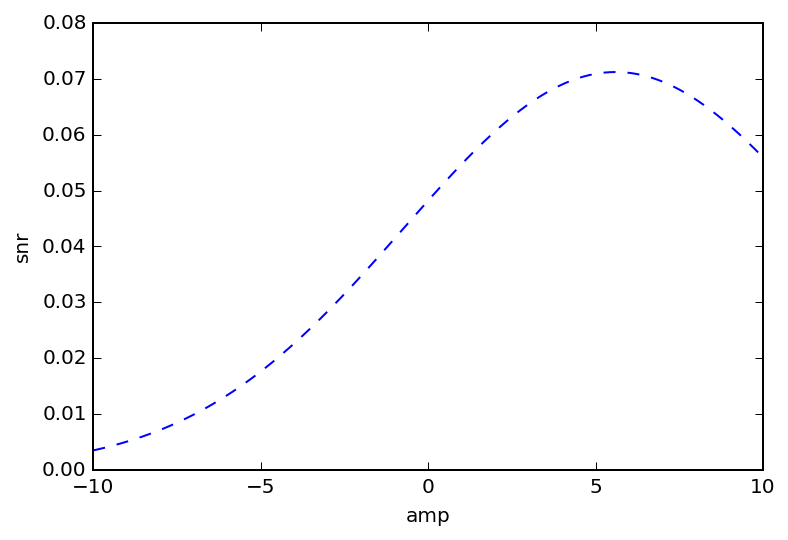

In [290]:
n_events = 10
noise_level = 10 
multgauss = stackpdfs(n_events, noise_level)
plt.plot(amps, multgauss, '--',label='{0} combined'.format(n_events))
plt.xlabel('amp')
plt.ylabel("snr")
plt.show()

In [ ]:
from tqdm import tqdm
# this takes around 8 hours right now
n = 100
n_events = np.logspace(0,3,10)

stds_arr = []
for i in tqdm(range(n)):
    stds = []
    for n_event in n_events: 
        stacked = stackpdfs(n_event, noise_level)
        stds.append(np.std(stacked))
    plt.scatter(n_events,stds,lw=3,alpha=.5, color='b')
    stds_arr.append(stds)
    
plt.xlabel('Number of events')
plt.ylabel("stdev")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)
 23%|██▎       | 23/100 [2:12:43<7:43:19, 361.04s/it]

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


65537 131072


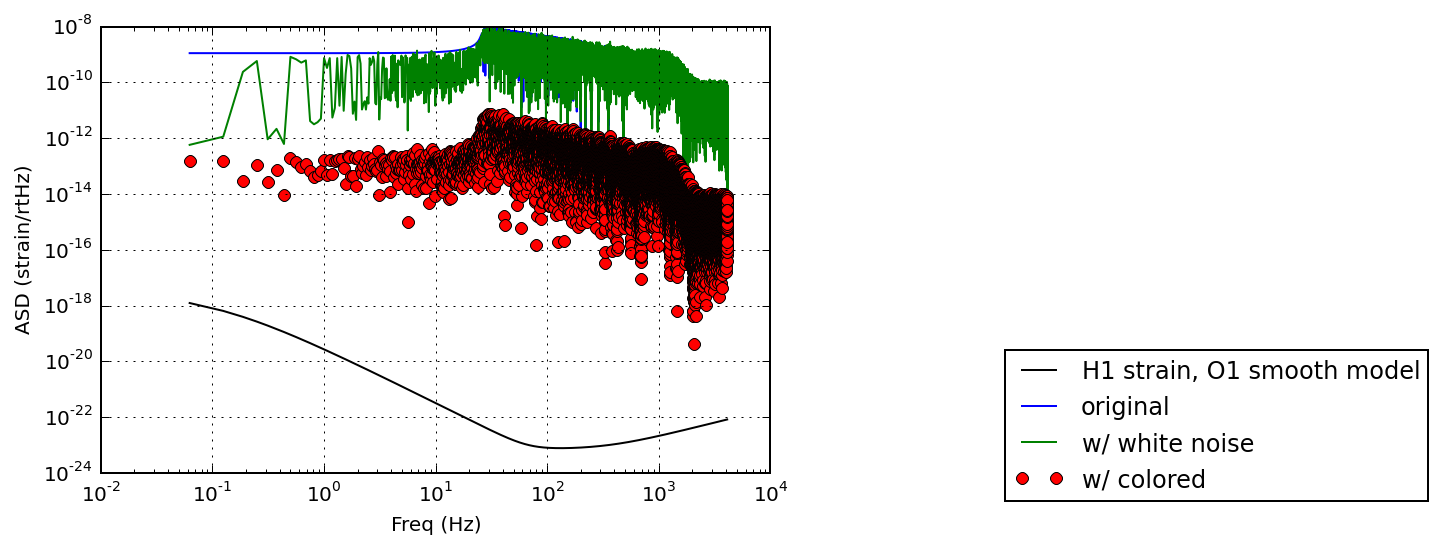

65537 131072


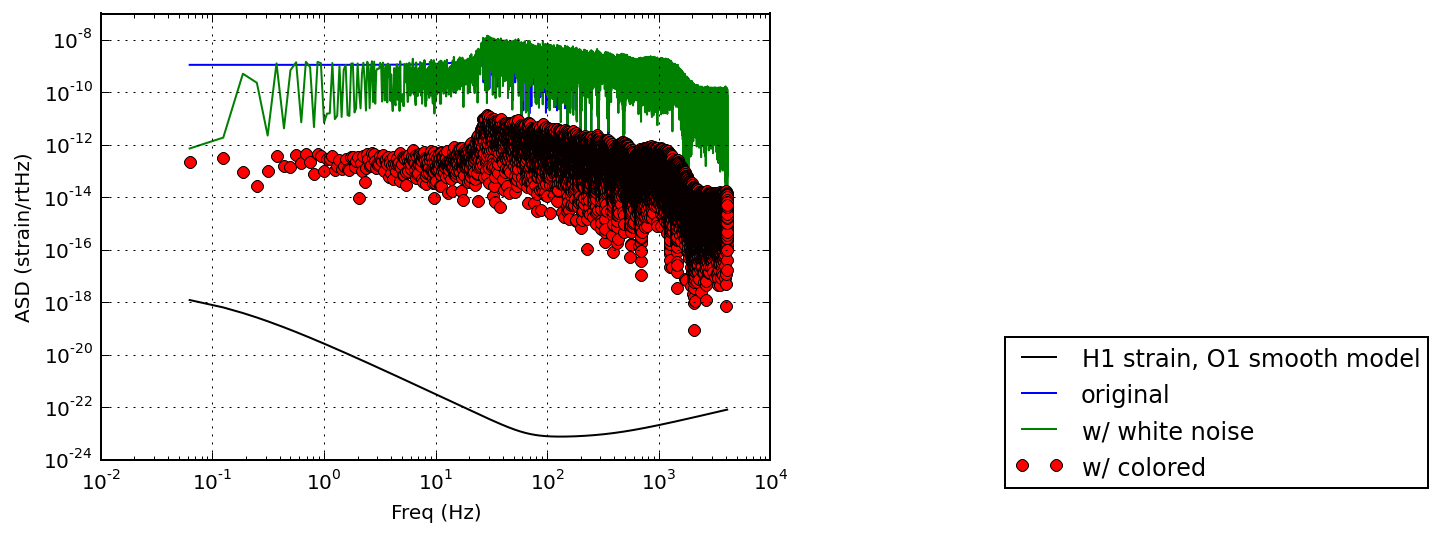

In [20]:
# Next I'm going to add some noise to my faux signals to create some faux data
# I'm adding white noise to the template and seeing how the SNR 
# changes as a function of the added noise

def color_it(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf * (np.sqrt(interp_psd(freqs) /dt/2.))
    color_ht = np.fft.irfft(white_hf, n=Nt)
    return(color_ht)


def addnoise(data_template, noise_level, colorit = False, plot=True):
        
    
    if noise_level==0:
        return(data_template.copy())
    else:    
        # add gaussian noise to template to make some data
        # take PSD of white noise & 
        # see where it lies compared to true PSD of LIGO
        # check where you start frequency & see how results depend on it
        Nt = len(data_template)
        freqs = np.fft.rfftfreq(Nt, dt)
        hf = np.fft.rfft(data_template)
        white_noise = np.random.normal(0,noise_level,len(freqs))*hf
        psd = interp1d(freqs, white_noise, fill_value='extrapolate')
        
        if colorit:
            color_hf = white_noise*(np.sqrt(psd(freqs) /dt/2.))
            color_ht = np.fft.irfft(psd(color_hf), n=Nt)
            c_whitenbp = filtfilt(bb, ab, whiten(color_ht,psd,dt))
            modified_template = color_ht
            print(len(freqs), len(c_whitenbp))
        else: 
            modified_template = np.fft.irfft(psd(white_noise), n=Nt)
    
        #Pxx_H1, freqs = mlab.psd(data_template, Fs = fs, NFFT = NFFT)
        #white_noise = Pxx_H1*np.random.normal(0,noise_level,len(freqs))
        #data = np.fft.ifft(white_noise*scale, n=len(data_template))
        #print(data)
        
        #print(psd_H1)
        #colored = color_it(white_noise,psd_H1,dt)
        #print(colored)
        

    if plot: 
        Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
        psd_smooth = interp1d(freqs, Pxx)
        plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
        #plt.axis([f_min, f_max, 1e-24, 1e-19])
        plt.grid('on')
        plt.ylabel('ASD (strain/rtHz)')
        plt.xlabel('Freq (Hz)')
        plt.loglog(freqs, np.sqrt(hf),'-', label='original')
        plt.loglog(freqs, np.sqrt(white_noise),'-', label='w/ white noise')
        if colorit: 
            plt.loglog(freqs, np.sqrt(color_hf),'o', label='w/ colored')
            #plt.loglog(freqs, np.sqrt(c_whitenbp),'o', label='c.whitened')
        plt.legend(bbox_to_anchor=(0., 0.2, 2, .102))
        plt.show()
        
    return(modified_template)


noise_levels = np.linspace(0,1,3)
GRdata_arr = [addnoise(GRtemplate, noise_level, plot=False) for noise_level in noise_levels]
GRcdata_arr = [addnoise(GRtemplate, noise_level, colorit=True) for noise_level in noise_levels]#, plot=False)


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


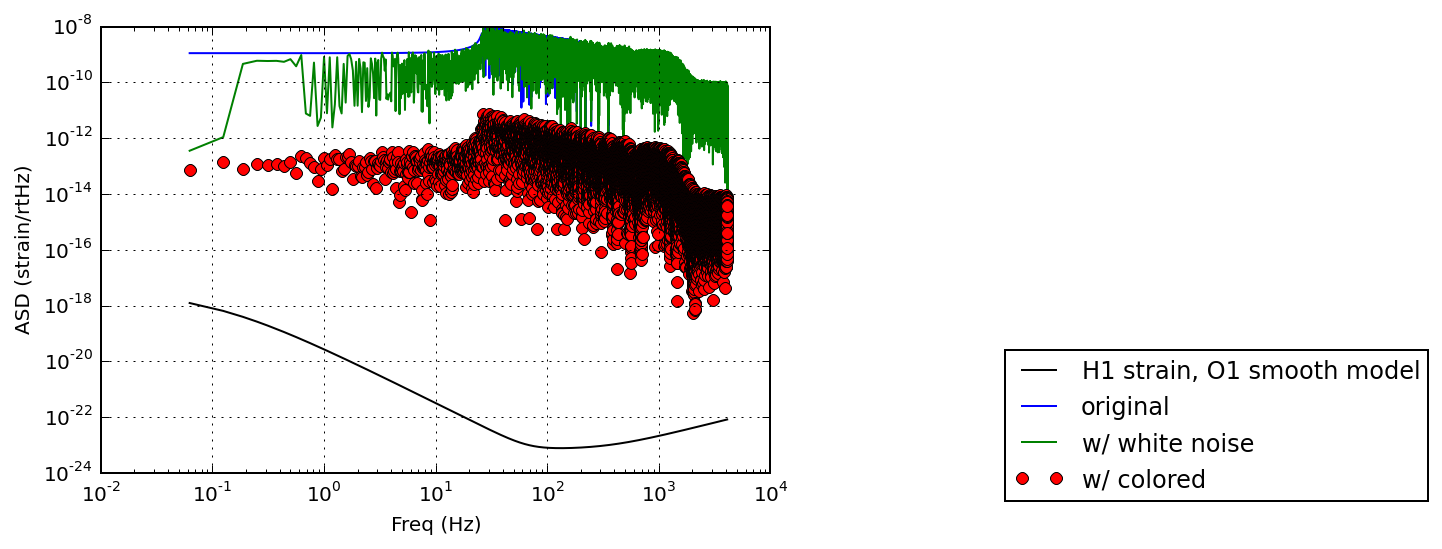

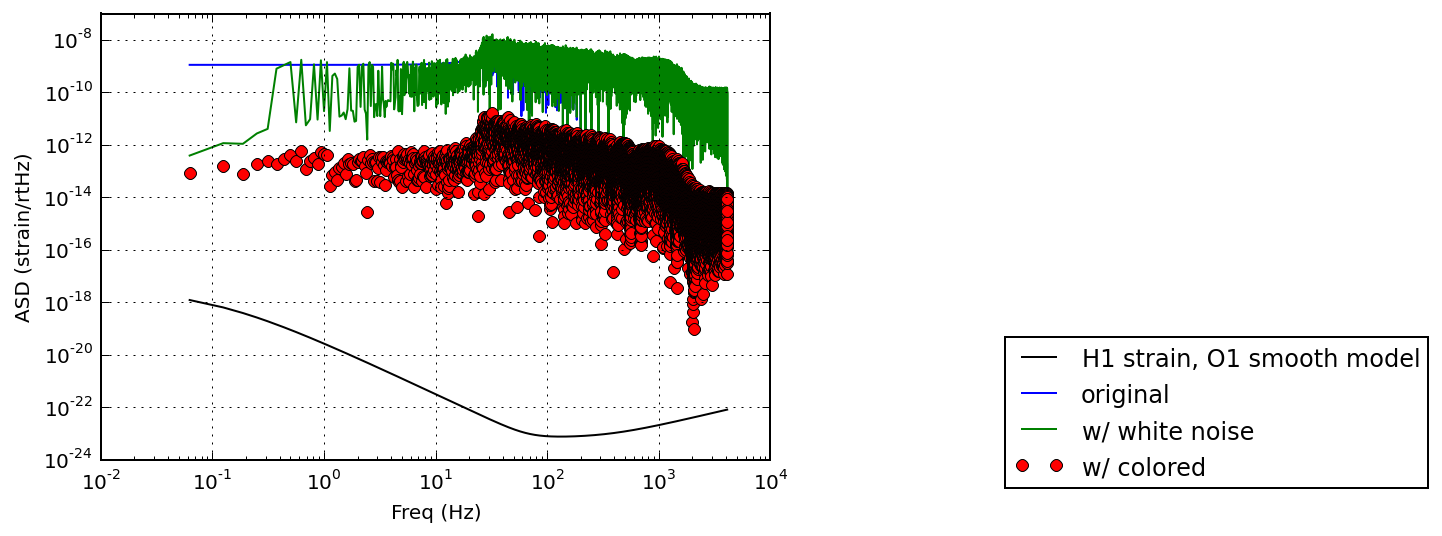

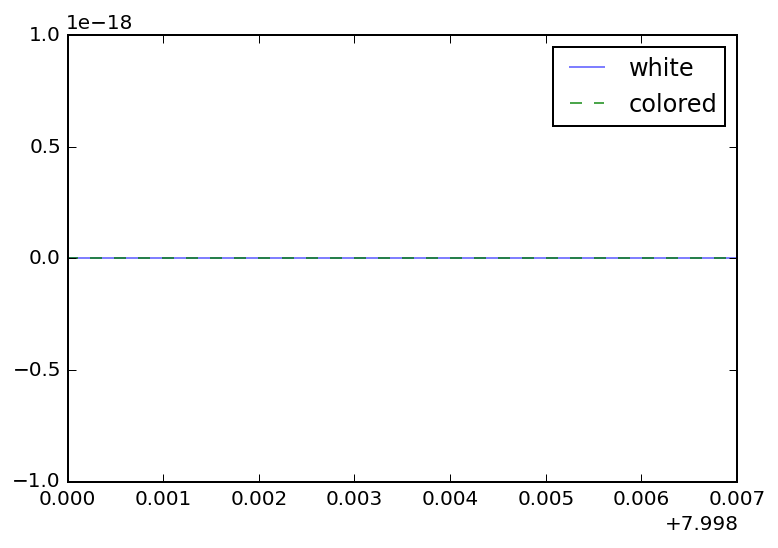

3 3


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in sqrt


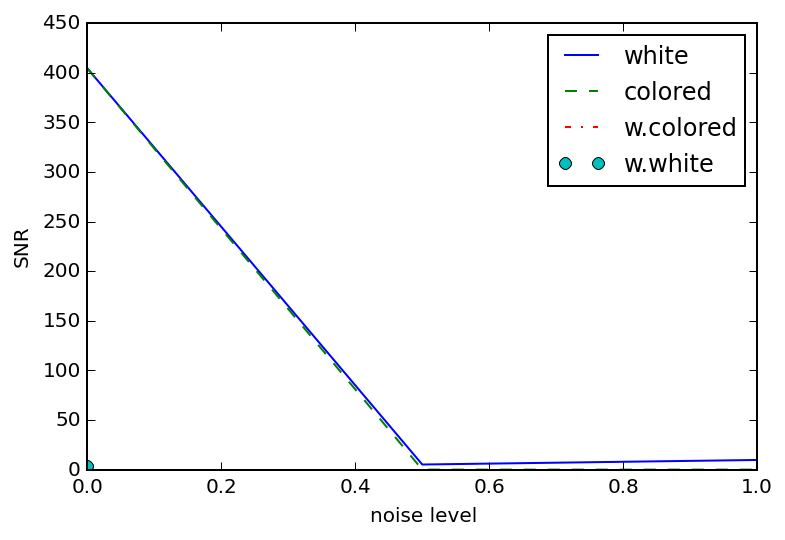

In [19]:

    



plt.plot(time, GRdata_arr[-1], alpha=0.5,label="white")
plt.plot(time, GRcdata_arr[-1], '--', alpha=0.7, label="colored")
plt.ylim(-10*scale,10*scale)
plt.xlim(7.998,8.005)
plt.legend()
plt.show()




GRsnr_arr = [matchfiltering(GRtemplate, data) for data in GRdata_arr]
GRcsnr_arr = [matchfiltering(GRtemplate, data) for data in GRcdata_arr]

GRwwsnr_arr = []
for data in GRdata_arr: 
    Pxx_H1, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT)
    psd = interp1d(freqs, Pxx_H1,fill_value='extrapolate')
    wcdata = whiten(data,psd,dt)
    fwcdata = filtfilt(bb, ab, wcdata)
    SNRmax = matchfiltering(GRtemplate, fwcdata)
    GRwwsnr_arr.append(SNRmax)

GRwcsnr_arr = []
for data in GRcdata_arr: 
    Pxx_H1, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT)
    psd = interp1d(freqs, Pxx_H1,fill_value='extrapolate')
    wcdata = whiten(data,psd,dt)
    fwcdata = filtfilt(bb, ab, wcdata)
    SNRmax = matchfiltering(GRtemplate, fwcdata)
    GRwcsnr_arr.append(SNRmax)

print(len(noise_levels), len(GRsnr_arr))
plt.plot(noise_levels,GRsnr_arr, label="white")
plt.plot(noise_levels,GRcsnr_arr,'--',label="colored")
plt.plot(noise_levels,GRwcsnr_arr,'-.',label="w.colored")
plt.plot(noise_levels,GRwwsnr_arr,'o',label="w.white")
plt.ylabel('SNR')
plt.xlabel('noise level')
plt.legend()
plt.show()


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


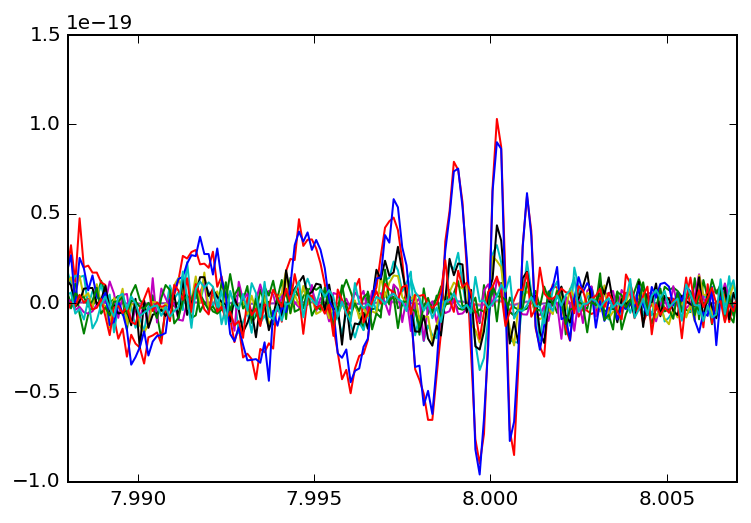

98 5.70663154866


In [306]:
templates[98].amp, templates[98].phase



(1.5, 1.7561698063545426)

Here I am generating faux data from a template (in template_number), match filtering it for various noise levels, and recovering the template number. I plot the template number recovered vs noise and SNR, the amplitude vs snr, and phase vs snr for the templates recovered. 

In [ ]:
template_number = 27
noise_levels = np.logspace(0,1000,10)
print(noise_levels)
#noise_levels = np.linspace(0,1000,100)
#moddata_arr = addnoise(templates[template_number].timeseries, noise_levels)
#cmoddata_arr = addnoise(templates[template_number].timeseries, noise_levels, colorit=True)

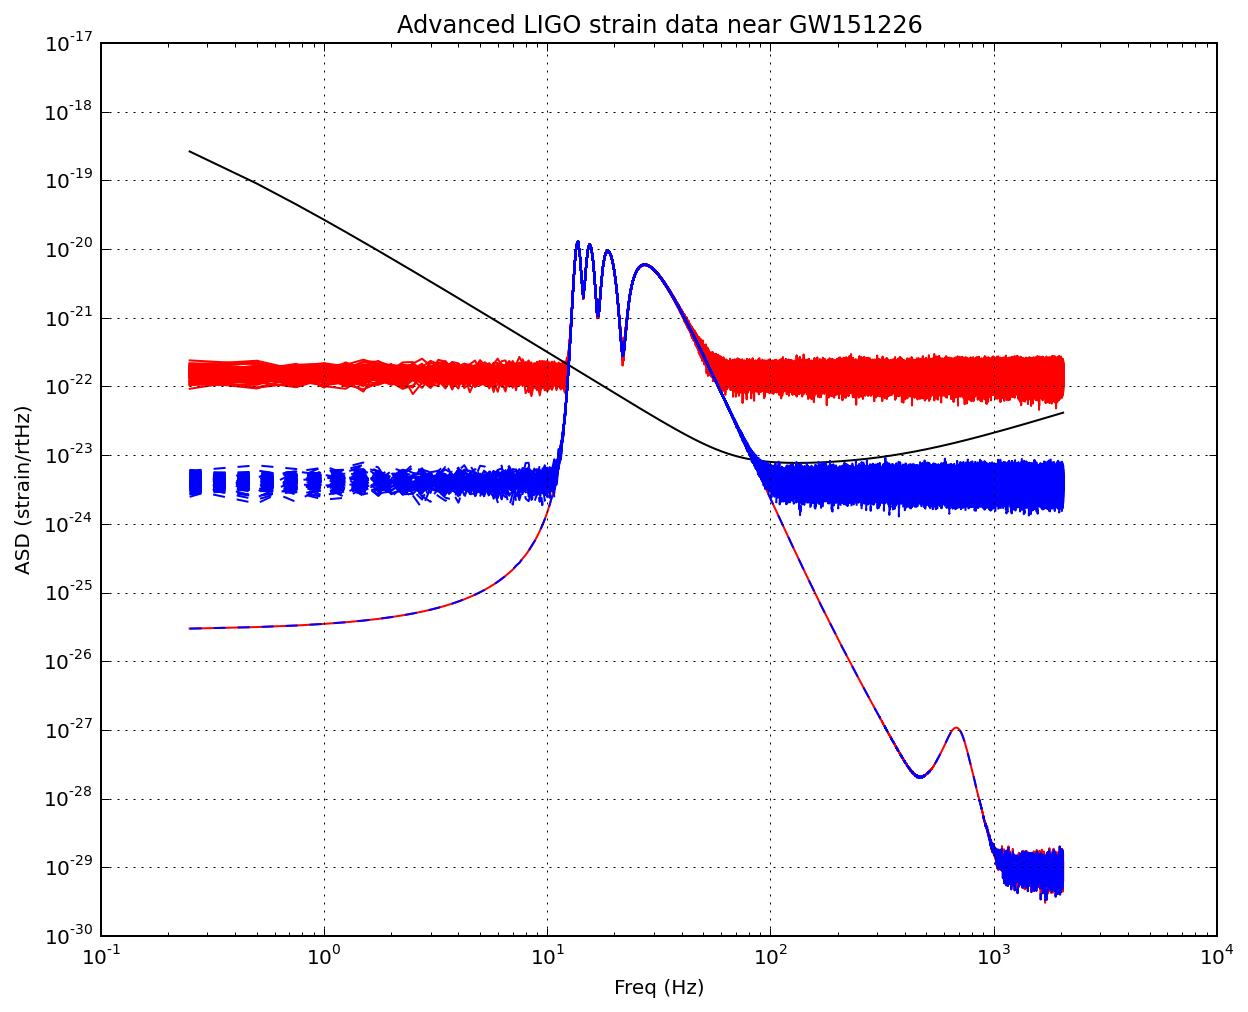

In [9]:
# plot ASD/strain equivalent noise vs frequency; mostly from 
# https://losc.ligo.org/s/events/GW151226/LOSC_Event_tutorial_GW151226.html

# plot the ASDs, with the template overlaid:
f_min = 20.
f_max = 2000. 
plt.figure(figsize=(10,8))
NFFT = 4*fs
# number of sample for the fast fourier transform:
psds = []
for data in moddata_arr:
    Pxx_H1, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT)
    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1,fill_value='extrapolate')
    psds.append(psd_H1)
    plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='template strain')

# Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
psd_smooth = interp1d(freqs, Pxx)
plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')


cpsds = []
for data in cmoddata_arr:
    Pxx_H1, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT)
    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1,fill_value='extrapolate')
    cpsds.append(psd_H1)
    plt.loglog(freqs, np.sqrt(Pxx_H1),'b',linestyle='--',label='template strain')


#plt.axis([f_min, f_max, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.title('Advanced LIGO strain data near '+eventname)

In [23]:
from tqdm import * 
recovered_templates = []
recovered_snrs = []

for i in tqdm(np.arange(len(moddata_arr))):
    data = moddata_arr[i]
    modsnr_arr = [matchfiltering(template.timeseries,data) for template in templates]
    recovered_templates.append(np.argmax(modsnr_arr))
    recovered_snrs.append(np.max(modsnr_arr))


In [24]:
wmoddata_arr = []
for i,data in enumerate(cmoddata_arr):
    psd = cpsds[i]
    strain_H1_whiten = whiten(data,psd,dt)
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
    wmoddata_arr.append(strain_H1_whitenbp)
    
crecovered_templates = []
crecovered_snrs = []
for i in tqdm(np.arange(len(wmoddata_arr))):
    data = wmoddata_arr[i]
    modsnr_arr = [matchfiltering(template.timeseries,data) for template in templates]
    crecovered_templates.append(np.argmax(modsnr_arr))
    crecovered_snrs.append(np.max(modsnr_arr))

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in sqrt


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


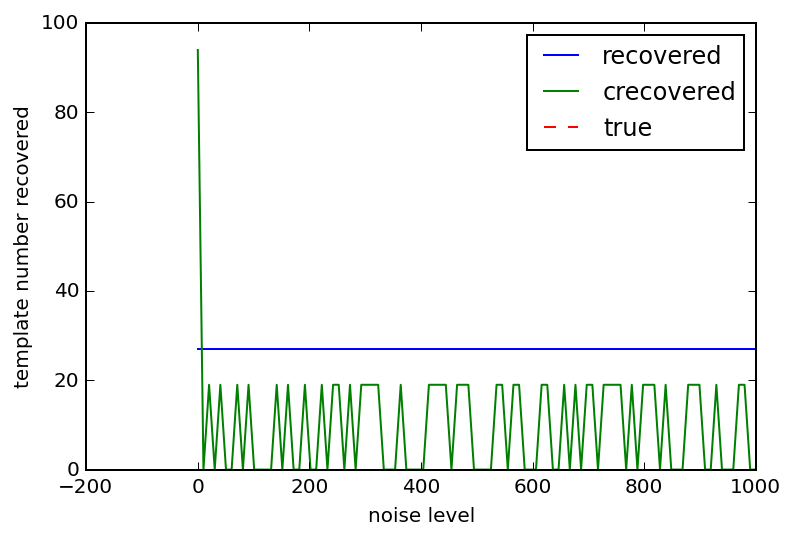

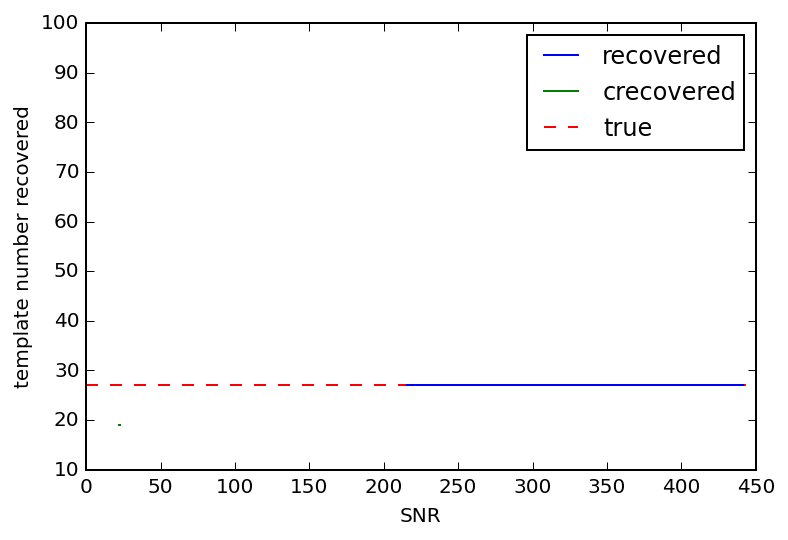

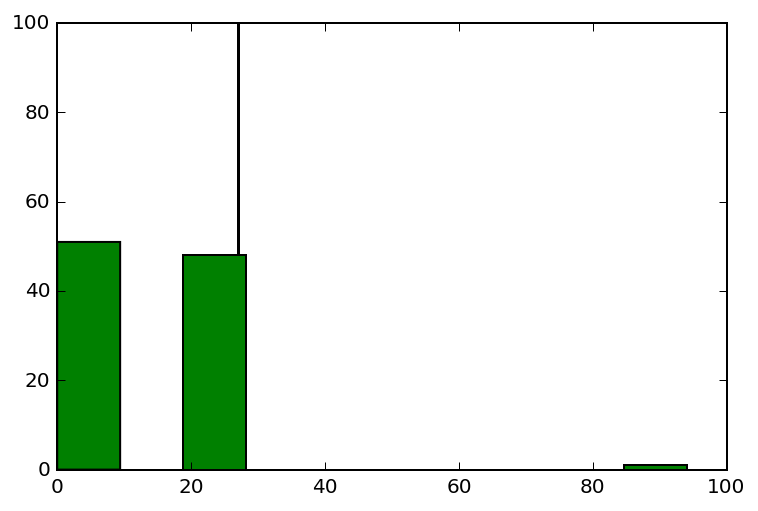

In [25]:
plt.plot(noise_levels,recovered_templates, label="recovered")
plt.plot(noise_levels,crecovered_templates, label="crecovered")
plt.hlines(template_number, xmin=-1, 
           xmax=11, linestyle='--',color='r', label="true")
plt.ylabel("template number recovered")
plt.xlabel("noise level")
plt.legend()
plt.show()


plt.plot(recovered_snrs,recovered_templates, label="recovered")
plt.plot(crecovered_snrs,crecovered_templates, label="crecovered")
plt.ylabel("template number recovered")
plt.xlabel("SNR")
plt.hlines(template_number, xmin=0, 
           xmax=450,linestyle='--',color='r', label="true")
plt.legend()
plt.show()

plt.hist(recovered_templates)
plt.hist(crecovered_templates)
plt.show()


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


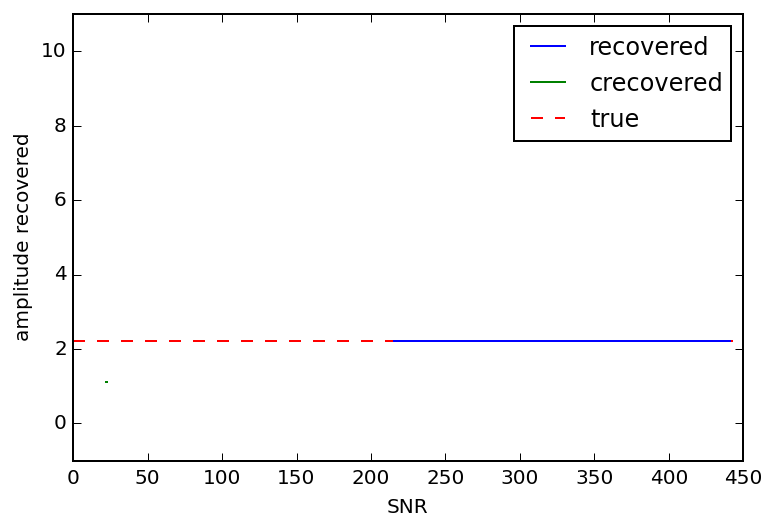

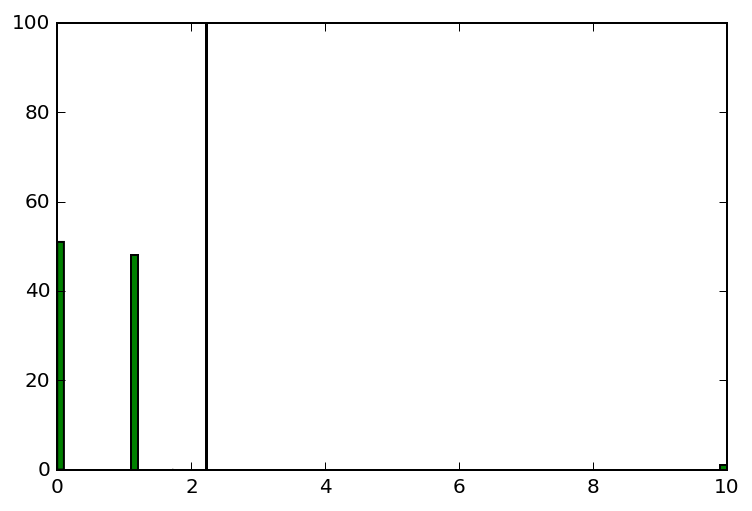

[23.061330561879231, nan, 22.75583366468824, nan, 22.647056332180895, nan, nan, 22.446790800959963, nan, 22.58256323621854, nan, nan, nan, nan, 22.753486005167634, nan, 22.708899219986471, nan, nan, 22.484747779883911, nan, nan, 22.615943908583745, nan, 22.176175753307501, 22.477219792158216, nan, 22.769299600459796, nan, 22.814227537046136, 22.667297864513248, 22.035787435392773, 22.713022771297709, nan, nan, nan, 22.60562402201667, nan, nan, nan, nan, 22.838119978317529, 22.795270563374476, 22.595554313239322, 22.699761903478898, nan, 22.399803774730067, 22.738221215100396, 22.501482129861092, nan, nan, nan, nan, 22.536936105966099, 22.611836978824321, nan, 22.560944717856614, 22.662442762195621, nan, nan, nan, 22.680552588315098, 22.55217746718299, nan, nan, 22.13055348892485, nan, 22.320264101462087, nan, 22.80255578362954, 22.698681803658015, nan, 22.702870451814665, 22.550226301504448, 22.723944573720974, 22.372457188846088, nan, 22.77170087610747, nan, 22.726738709937205, 22.602

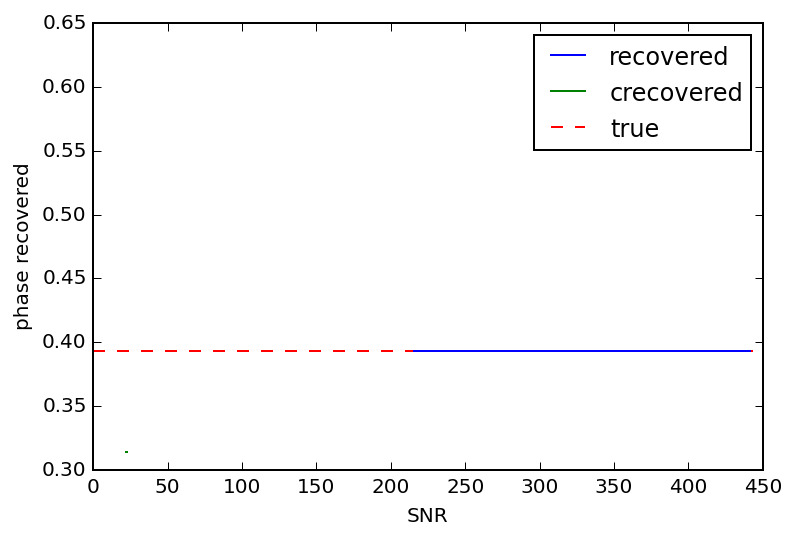

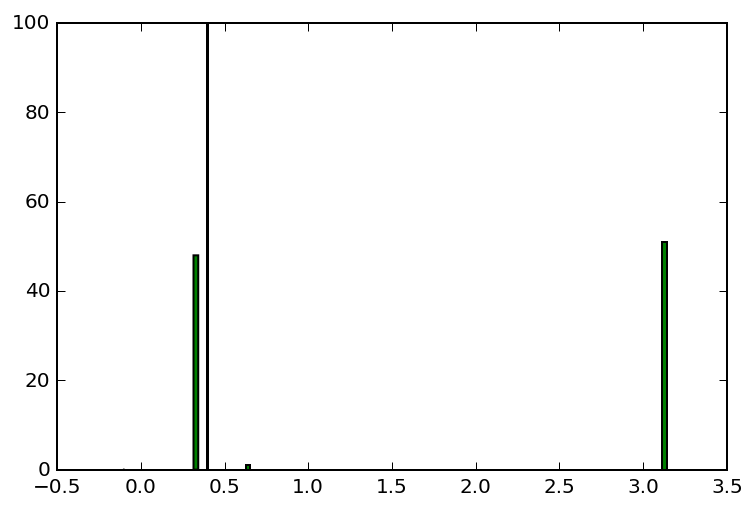

In [36]:
ramps, rphases = zip(*[(templates[num].amp, templates[num].phase) for num in recovered_templates])
cramps, crphases = zip(*[(templates[num].amp, templates[num].phase) for num in crecovered_templates])

plt.plot(recovered_snrs,ramps, label="recovered")
plt.plot(crecovered_snrs,cramps, label="crecovered")
plt.ylabel("amplitude recovered")
plt.xlabel("SNR")
plt.ylim(-1,11)
plt.hlines(templates[template_number].amp, xmin=0, xmax=450,linestyle='--',color='r', label="true")
plt.legend()
plt.show()

bins = 100 
plt.hist(ramps,bins=bins)
plt.hist(cramps, bins=bins)
plt.show()

plt.plot(recovered_snrs,rphases, label="recovered")
plt.plot(crecovered_snrs,crphases, label="crecovered")
plt.ylabel("phase recovered")
plt.xlabel("SNR")
plt.hlines(templates[template_number].phase, xmin=0, xmax=450,linestyle='--',color='r', label="true")
plt.legend()
plt.show()

plt.hist(rphases, bins=bins)
plt.hist(crphases, bins=bins)
plt.show()

It looks like the amplitude scale can be recovered down to ~20 SNR, but phase isn't recovered very well at all! I think aLIGO works with SNR ~ 12. 


Now I want to generate noisy signals from BBH mergers with 10-50 solar masses. Afterwards, I want to template match these and create a probability distribution of its phase and amplitude parameters. Then I can stack these phase and amplitude parameters to find how the uncertainty shrinks. 

In [22]:
# now that I have the templates for match filtering, I want to create some faux data
# first I take the initial, GR-conforming template and scale it so it represents a different mass fraction
# I then interpolate it back into the time domain

def scale_waveform(m1,m2,template):
    
    # total mass
    m_tot = m1 + m2 
    # symmetric mass ratio
    nu = (m1 * m2)/(m_tot)
    # chirp mass
    m_chirp = nu**(3/5)*m_tot
    r = 1
    
    # transform to freq domain
    Nt = len(template)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(template)

    modified_amps = []
    for i,freq in enumerate(freqs): 
        # orbital angular frequency
        omega = 2*np.pi*freq
        # amplitude
        amp = 1/r * m_chirp**(5/3) * omega**(2/3)
        modified_amps.append(hf[i]*amp)
        
    # interpolate? 
    temp = interp1d(freqs, modified_amps,fill_value='extrapolate')
    # then transform back
    modified_template = np.fft.irfft(temp(modified_amps), n=Nt)

    return(modified_template)



/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


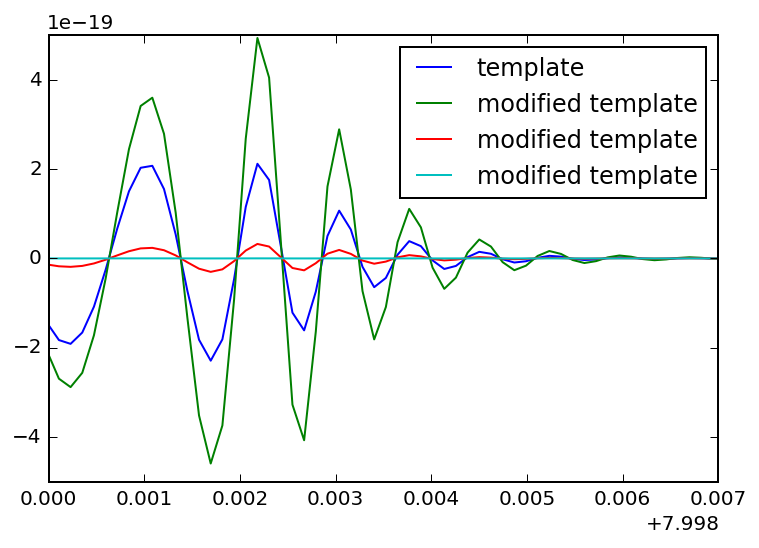

In [23]:
    


# scale 
m1 = 500
m2 = 500
t1 = scale_waveform(m1,m2, GRtemplate)
t2 = scale_waveform(300,300, GRtemplate)
t3 = scale_waveform(100,100, GRtemplate)



scale = 10**-19
plt.plot(time, GRtemplate, label="template")
plt.plot(time, t1, label="modified template")
plt.plot(time, t2, label="modified template")
plt.plot(time, t3, label="modified template")
plt.ylim(-5*scale,5*scale)
plt.legend(loc=0)
plt.xlim(7.998,8.005)
plt.show()

#t_chirp = 5/96*m_tot/nu*(m_tot/r_int)**(-4)



In [24]:
import random
random.seed(10)

# let's make n signals
n = 10
m1_arr = np.random.uniform(100,500,n)
m2_arr = np.random.uniform(100,500,n)

signal_arr = [scale_waveform(m1_arr[i],m2_arr[i], GRtemplate) for i in np.arange(len(m1_arr))]


# add noise to faux signals
noise_level = 50




noisy_signal_arr = [quickwhitenoise(signal, noise_level) for signal in signal_arr]



/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


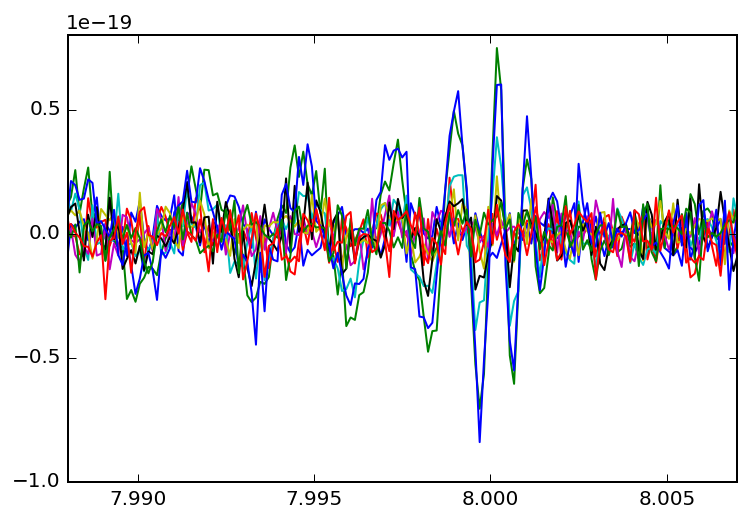

In [25]:

#plt.plot(time, GRtemplate, label="template")
for i,h in enumerate(noisy_signal_arr):
    plt.plot(time, h, label="modified template")

#plt.ylim(-2.5*scale,2.5*scale)
#plt.legend(loc=0)
plt.xlim(7.988,8.007)
plt.show()


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


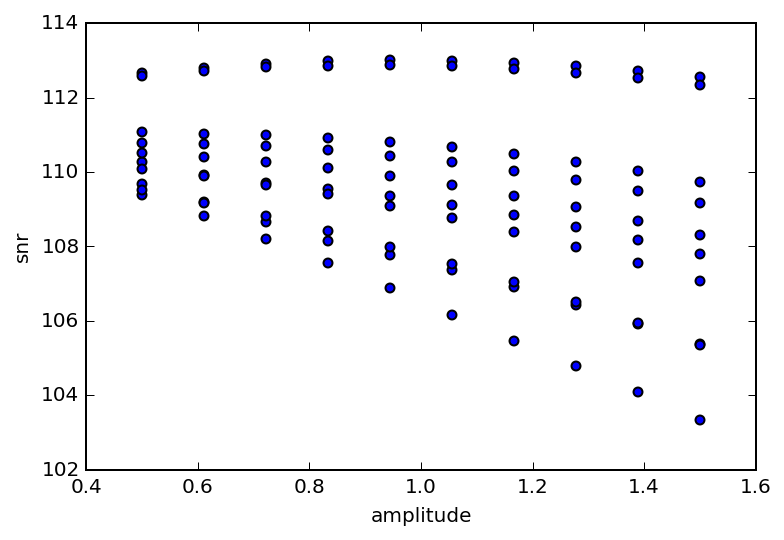

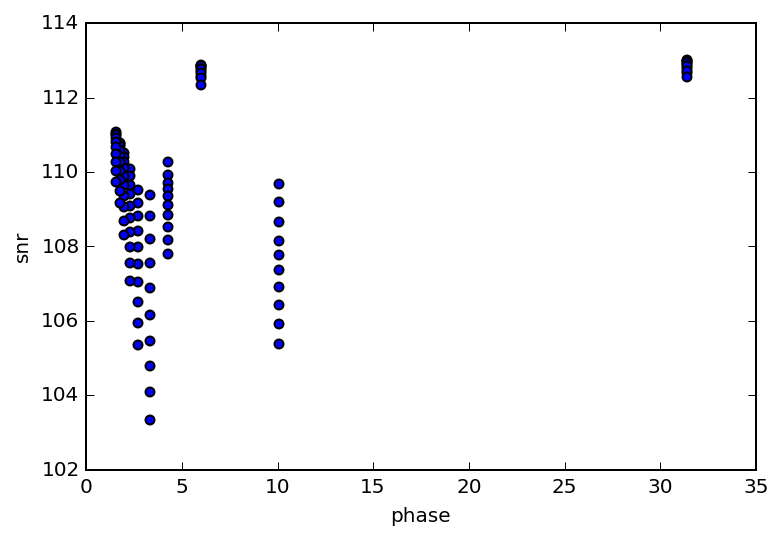

"\namps = []\nphases = []\nfor i in recovered_templates: \n    amps.append(templates[i].amp)\n    phases.append(templates[i].phase)\nbins = 50\nplt.hist(amps, bins=bins)\nplt.title('amps')\nplt.show()\nplt.title('phases')\nplt.hist(phases, bins=bins)\nplt.show()\n\nprint('amp: ',np.mean(amps), np.var(amps))\nprint('phase: ',np.mean(phases), np.var(phases))\n"

In [29]:

# now I want to match filter each of my noisy signals? 

noise_level = 100
template = GRtemplate#signal_arr[0]

data = quickwhitenoise(template, noise_level)


snr_arr = [matchfiltering(template.timeseries,data) for template in templates]

    
amps = [template.amp for template in templates]
phases = [template.phase for template in templates]


plt.scatter(amps,snr_arr)
plt.ylabel('snr')
plt.xlabel('amplitude')
plt.show()

plt.scatter(phases,snr_arr)
plt.ylabel('snr')
plt.xlabel('phase')
plt.show()

'''
amps = []
phases = []
for i in recovered_templates: 
    amps.append(templates[i].amp)
    phases.append(templates[i].phase)
bins = 50
plt.hist(amps, bins=bins)
plt.title('amps')
plt.show()
plt.title('phases')
plt.hist(phases, bins=bins)
plt.show()

print('amp: ',np.mean(amps), np.var(amps))
print('phase: ',np.mean(phases), np.var(phases))
'''

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


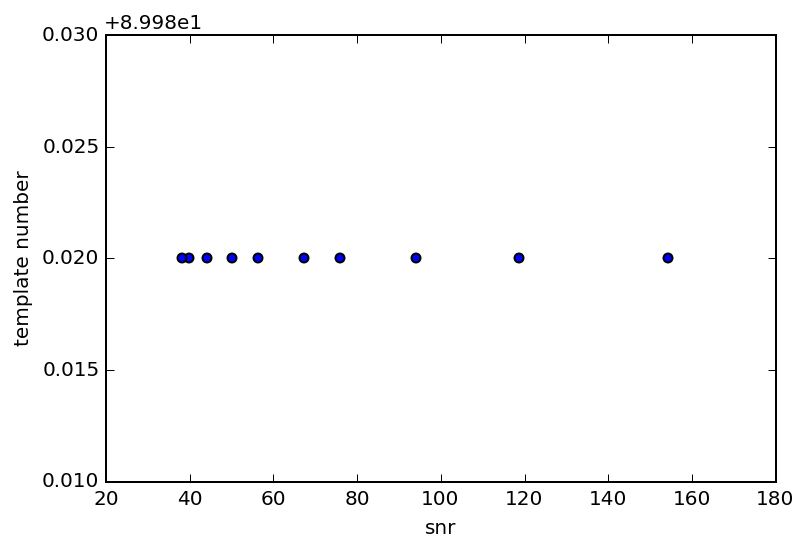

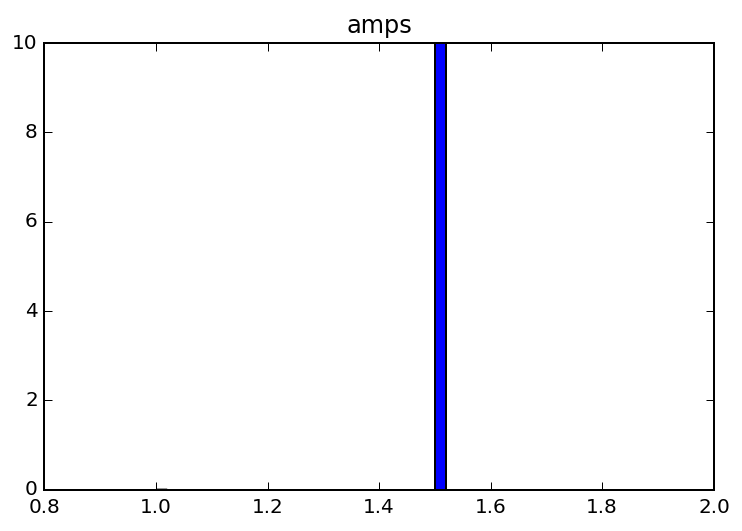

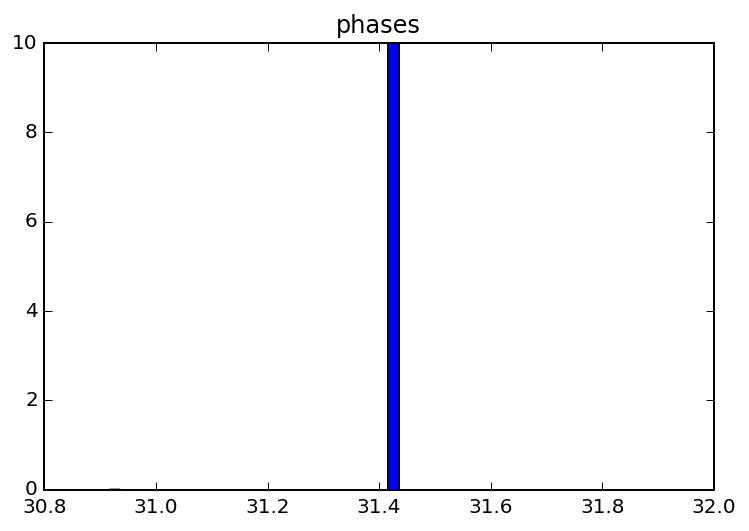

amp:  1.5 0.0
phase:  31.4159265359 0.0


amp:  1.5 0.0
phase:  12.2848141924 159.910646545


For detector template, maximum at 8.0001 with SNR = 155.8, D_eff = 0.52, horizon = 10.1 Mpc


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


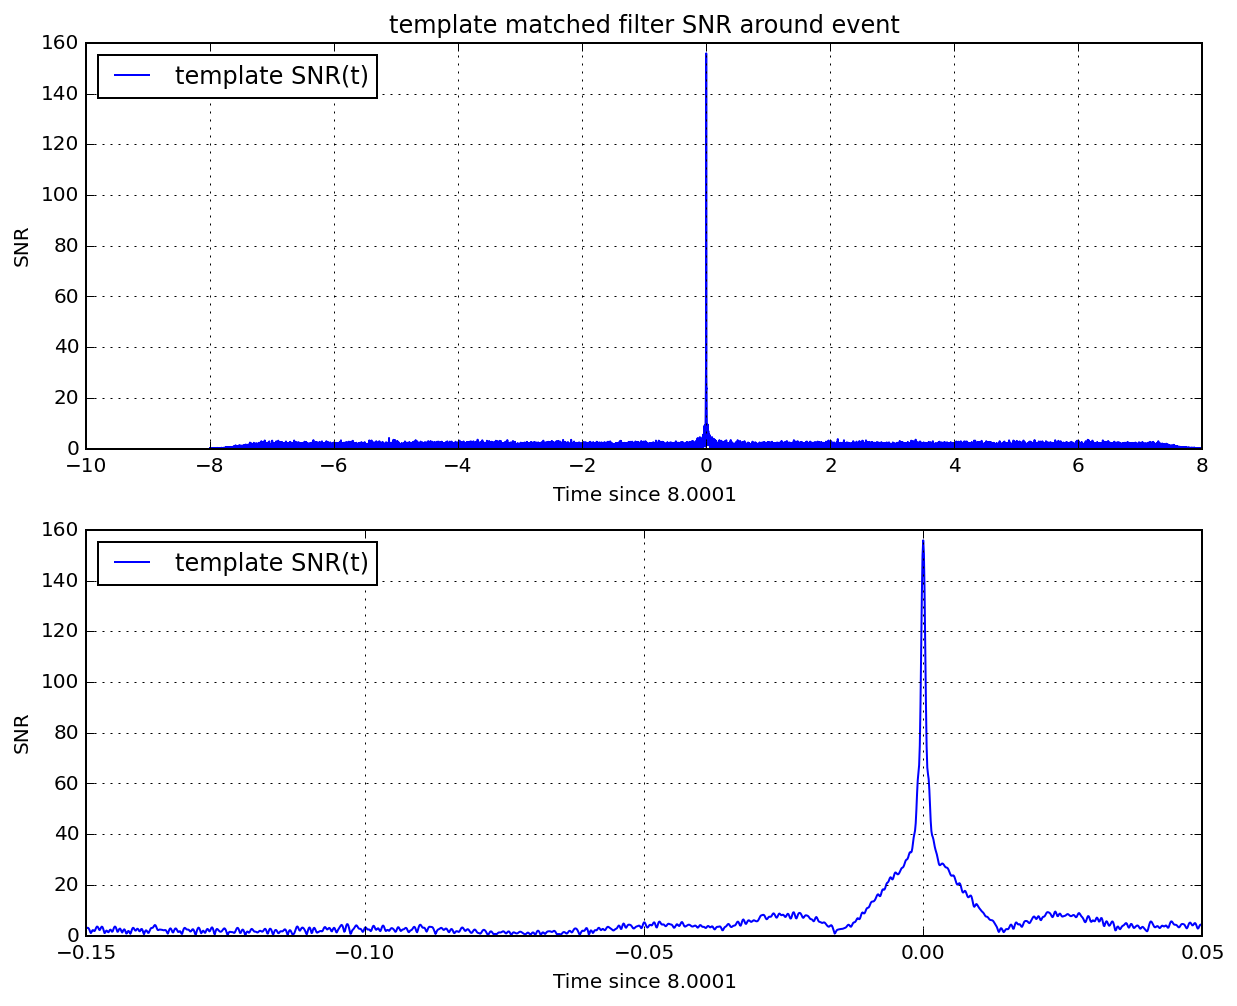

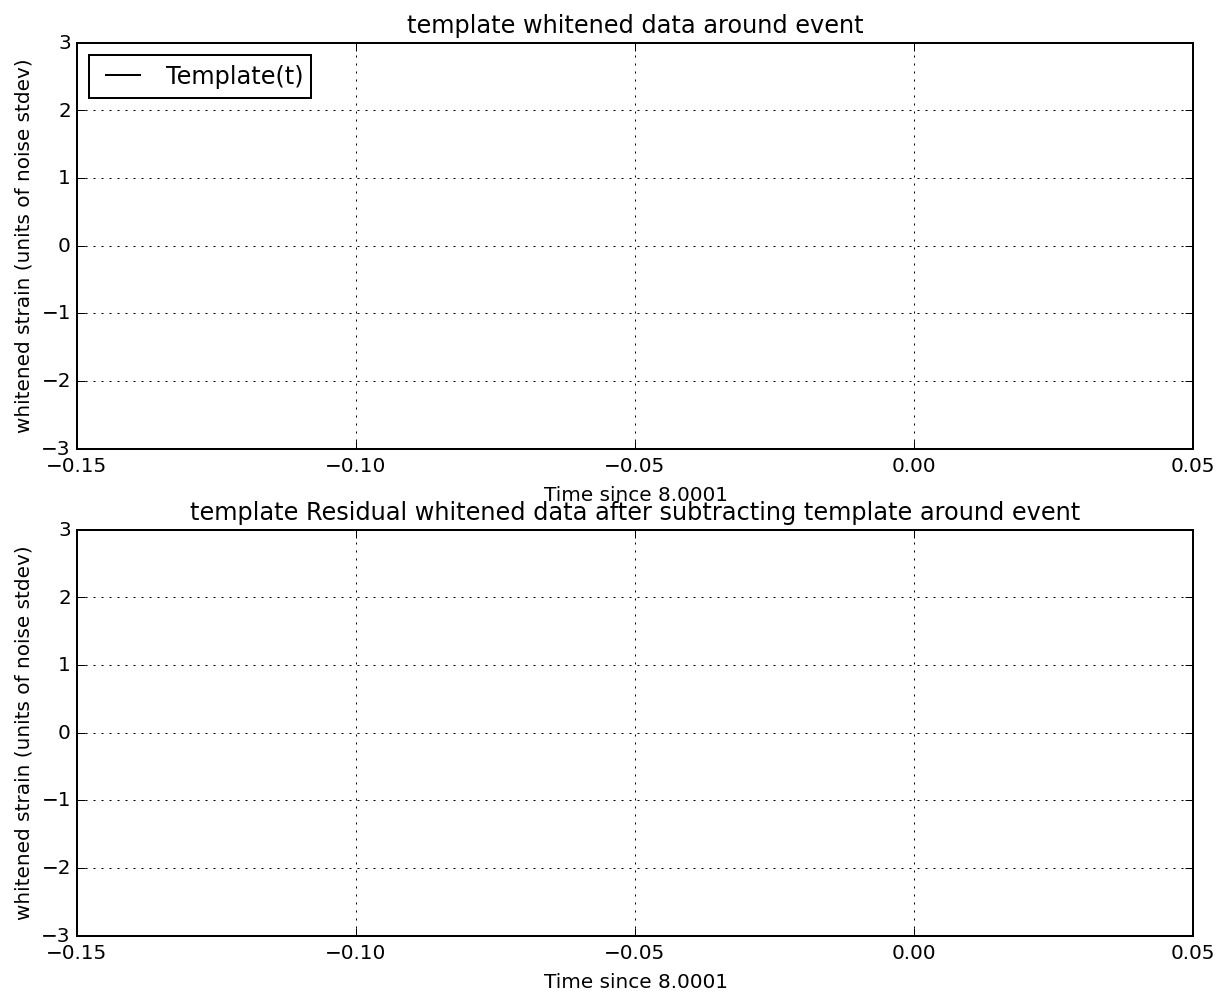

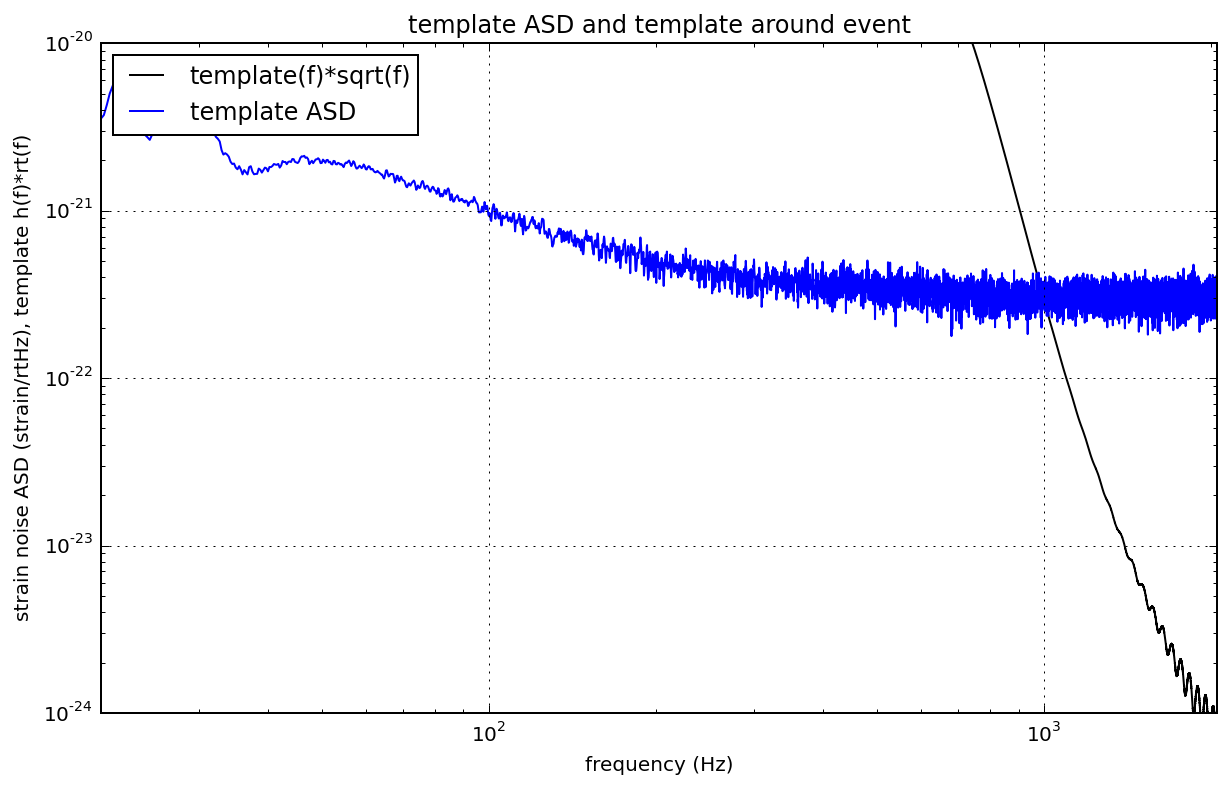

In [85]:
# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2


# We will record the time where the data match the END of the template.
etime = time+template_offset
# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs


# -- Calculate the PSD of the data.  Also use an overlap, and window:
data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

# Take the Fourier Transform (FFT) of the data and the template (with dwindow)
data_fft = np.fft.fft(data*dwindow) / fs

# -- Interpolate to get the PSD values at the needed frequencies
power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

# -- Calculate the matched filter output in the time domain:
# Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
# Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
# so the result will be plotted as a function of time off-set between the template and the data:
optimal = data_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)*fs

# -- Normalize the matched filter output:
# Normalize the matched filter output so that we expect a value of 1 at times of just noise.
# Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR_complex = optimal_time/sigma

# shift the SNR vector by the template length so that the peak is at the END of the template
peaksample = int(data.size / 2)  # location of peak in the template
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

# find the time and SNR value at maximum:
indmax = np.argmax(SNR)
timemax = time[indmax]
SNRmax = SNR[indmax]

# Calculate the "effective distance" (see FINDCHIRP paper for definition)
# d_eff = (8. / SNRmax)*D_thresh
d_eff = sigma / SNRmax
# -- Calculate optimal horizon distnace
horizon = sigma/8

# Extract time offset and phase at peak
phase = np.angle(SNR_complex[indmax])
offset = (indmax-peaksample)
#print offset

# apply time offset, phase, and d_eff to whitened template, for plotting
#template_whitened = (template_p_whitenbp + template_c_whitenbp*1.j) 
template_whitened = template
template_phaseshifted = np.real(template_whitened*np.exp(1j*phase))
template_match = np.roll(template_phaseshifted,offset) / d_eff

#strain_whitenbp = filtfilt(bb, ab, whiten(strain_L1,psd_L1,dt))


det = 'template'
print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, D_eff = {3:.2f}, horizon = {4:0.1f} Mpc' 
      .format(det,timemax,SNRmax,d_eff,horizon))
# -- Plot the result
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(time-timemax, SNR,label=det+' SNR(t)')
#plt.ylim([0,25.])
plt.grid('on')
plt.ylabel('SNR')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.legend(loc='upper left')
plt.title(det+' matched filter SNR around event')

# zoom in
plt.subplot(2,1,2)
plt.plot(time-timemax, SNR,label=det+' SNR(t)')
plt.grid('on')
plt.ylabel('SNR')
plt.xlim([-0.15,0.05])
#plt.xlim([-0.3,+0.3])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.legend(loc='upper left')

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
#plt.plot(time-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
plt.plot(time-tevent,template_match,'k',label='Template(t)')
plt.ylim([-3,3])
plt.xlim([-0.15,0.05])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.ylabel('whitened strain (units of noise stdev)')
plt.legend(loc='upper left')
plt.title(det+' whitened data around event')

plt.subplot(2,1,2)
#plt.plot(time-tevent,strain_whitenbp-template_match,pcolor,label=det+' resid')
plt.ylim([-3,3])
plt.xlim([-0.15,0.05])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.ylabel('whitened strain (units of noise stdev)')
plt.legend(loc='upper left')
plt.title(det+' Residual whitened data after subtracting template around event')


# -- Display PSD and template
# must multiply by sqrt(f) to plot template fft on top of ASD:
plt.figure(figsize=(10,6))
template_f = np.absolute(template_fft)*np.sqrt(np.abs(datafreq)) / d_eff
plt.loglog(datafreq, template_f, 'k', label='template(f)*sqrt(f)')
plt.loglog(freqs, np.sqrt(data_psd), label=det+' ASD')
plt.xlim(20, fs/2)
plt.ylim(1e-24, 1e-20)
plt.grid()
plt.xlabel('frequency (Hz)')
plt.ylabel('strain noise ASD (strain/rtHz), template h(f)*rt(f)')
plt.legend(loc='upper left')
plt.title(det+' ASD and template around event')


# References

(<a id="cit-abbott2016b" href="#call-abbott2016b">LIGO and {Abbott}, 2016</a>) LIGO {The and {Abbott} B.~P., ``_Calibration of the Advanced LIGO detectors for the discovery of the binary black-hole merger GW150914_'', ArXiv e-prints, vol. , number , pp. , February 2016.

(<a id="cit-Feedback2005" href="#call-Feedback2005">Bechhoefer, 2005</a>) Bechhoefer John, ``_Feedback for physicists: A tutorial essay on control_'', Rev. Mod. Phys., vol. 77, number , pp. 783--836, Aug 2005.  [online](http://link.aps.org/doi/10.1103/RevModPhys.77.783)

